# Оптимизация процесса для ООО «Так закаляем сталь»
Заказчиком предоставлены данные о производственном процессе обработки стали, включаюшие данные об электродах, данные о подаче сыпучих материалов, данные о подаче добавок, данные о продувке сплава газом и результаты измерения температуры. Целью проекта является построение модели машинного обучения, которая на основе предоставленных данных предскажет конечную температуру плавления стали.

## Описание производственного процесса
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

## Предоставленные данные

Данные состоят из файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План исследования

1. Загрузка и обзор данных

<p style="line-height:1em;"></p>

2. Подготовка данных

    2.1. Обработка аномалий и пропусков по каждому датафрейму
    
    2.2. Формирование нового объединяющего датафрейма
    
    2.3. Выявление параметров модели в общем датафрейме

<p style="line-height:1em;"></p>

3. Обучение моделей

    3.1. Разделение на тренировочную и тестовые выборки
    
    3.2. Обучение моделей
    
    3.3. Анализ, выявление наиболее эффективной модели
    
    3.4. Проверка модели на тестовой выборке

<p style="line-height:1em;"></p>

4. Общие выводы


## Загрузка и обзор данных

В данном разделе, после импорта необходимых библиотек, откроем каждый из предоставленных датафреймов, произведем первичный осмотр данных, наметим работы по подготовке данных.

### Импортируем все необходимые для проекта библиотеки

In [1]:
#!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostRegressor

### Данные об электродах

In [2]:
try:
    data_arc = pd.read_csv('data_arc_new.csv')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')

In [3]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [5]:
print("Количество уникальных ключей:", data_arc['key'].nunique())

Количество уникальных ключей: 3214


In [6]:
print(data_arc[['Активная мощность', 'Реактивная мощность']].describe())

       Активная мощность  Реактивная мощность
count       14876.000000         14876.000000
mean            0.662752             0.438986
std             0.258885             5.873485
min             0.223120          -715.479924
25%             0.467115             0.337175
50%             0.599587             0.441639
75%             0.830070             0.608201
max             1.463773             1.270284


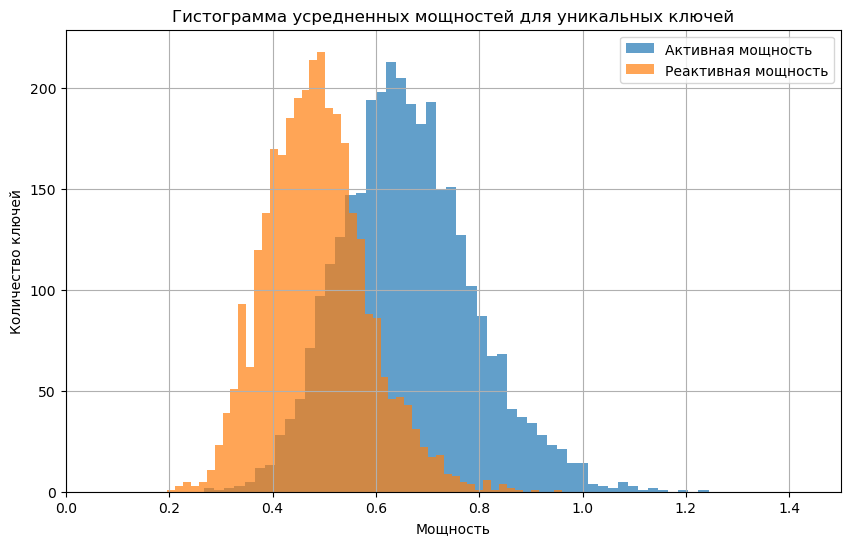

In [7]:
active_mean = data_arc.groupby('key')['Активная мощность'].mean()
reactive_mean = data_arc.groupby('key')['Реактивная мощность'].mean()
reactive_mean = reactive_mean[reactive_mean > 0]

plt.figure(figsize=(10,6))
active_mean.hist(alpha=0.7, bins=50, label='Активная мощность')
reactive_mean.hist(alpha=0.7, bins=50, label='Реактивная мощность')
plt.legend()
plt.xlabel("Мощность")
plt.ylabel("Количество ключей")
plt.title("Гистограмма усредненных мощностей для уникальных ключей")
plt.xlim(0, 1.5)
plt.show()

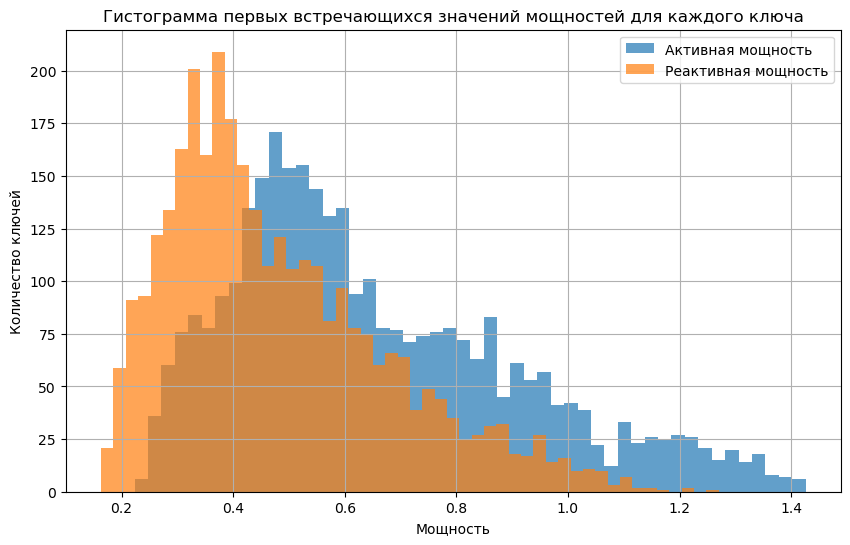

In [8]:
# Выбираем первое значение активной и реактивной мощностей для каждого ключа
first_values = data_arc.groupby('key')[['Активная мощность', 'Реактивная мощность']].first()

# Гистограммы
plt.figure(figsize=(10,6))
first_values['Активная мощность'].hist(alpha=0.7, bins=50, label='Активная мощность')
first_values['Реактивная мощность'].hist(alpha=0.7, bins=50, label='Реактивная мощность')
plt.legend()
plt.xlabel("Мощность")
plt.ylabel("Количество ключей")
plt.title("Гистограмма первых встречающихся значений мощностей для каждого ключа")
plt.show()

<b>Вывод по датафрейму</b>:
Данные не содержат пропусков. Присутствует информация по 3214 ключам. В данных есть ошибки, которые необходимо устранить на следующем этапе работы. 

### Данные о подаче сыпучих материалов (объем)

In [9]:
try:
    data_bulk = pd.read_csv('data_bulk_new.csv')
except:
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')

In [10]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [11]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [12]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


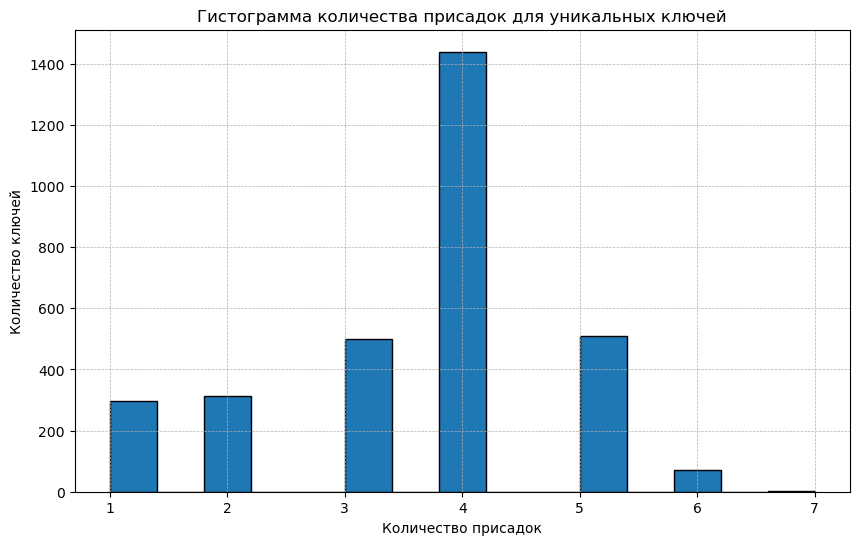

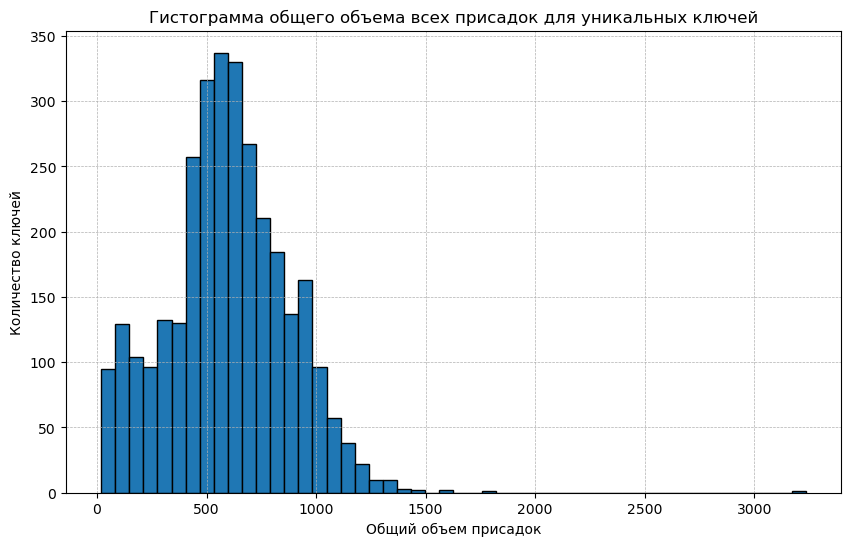

In [13]:
# Количество присадок для каждого уникального ключа
number_of_additives = data_bulk.iloc[:, 1:].notnull().sum(axis=1)

plt.figure(figsize=(10, 6))
number_of_additives.hist(bins=15, edgecolor='black')
plt.xlabel('Количество присадок')
plt.ylabel('Количество ключей')
plt.title('Гистограмма количества присадок для уникальных ключей')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Общий объем всех присадок для каждого уникального ключа
total_bulk_volume = data_bulk.iloc[:, 1:].sum(axis=1)

plt.figure(figsize=(10, 6))
total_bulk_volume.hist(bins=50, edgecolor='black')
plt.xlabel('Общий объем присадок')
plt.ylabel('Количество ключей')
plt.title('Гистограмма общего объема всех присадок для уникальных ключей')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

<b>Вывод по датафрейму</b>:
В одном процессе обработки стали используют до 7 сыпучих добавок, чаще всего от 3 до 5. 

### Данные о подаче сыпучих материалов (время)

In [14]:
try:
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
except:
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

In [15]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [16]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


<b>Вывод по датафрейму</b>:
Для каждого процесса по каждой присадке даны времена подачи. По условиям задачи, данные времена в дальнейшем анализироваться не будут.

### Данные о проволочных материалах

In [17]:
try:
    data_wire = pd.read_csv('data_wire_new.csv')
except:
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')

In [18]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [19]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


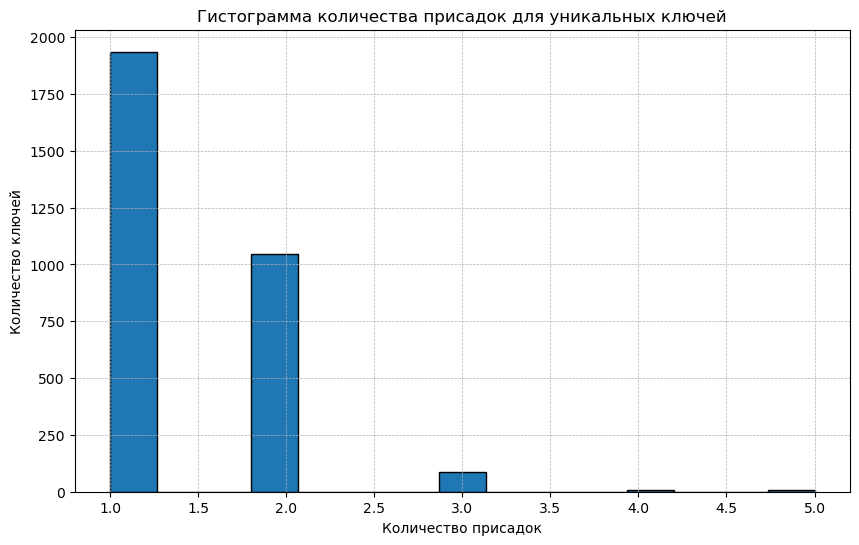

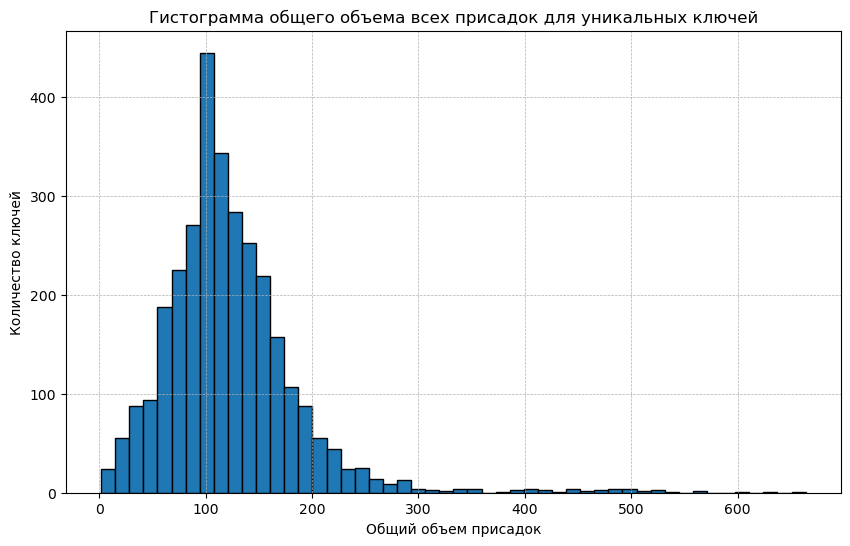

In [21]:
# Количество присадок для каждого уникального ключа
number_of_additives = data_wire.iloc[:, 1:].notnull().sum(axis=1)

plt.figure(figsize=(10, 6))
number_of_additives.hist(bins=15, edgecolor='black')
plt.xlabel('Количество присадок')
plt.ylabel('Количество ключей')
plt.title('Гистограмма количества присадок для уникальных ключей')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Общий объем всех присадок для каждого уникального ключа
total_bulk_volume = data_wire.iloc[:, 1:].sum(axis=1)

plt.figure(figsize=(10, 6))
total_bulk_volume.hist(bins=50, edgecolor='black')
plt.xlabel('Общий объем присадок')
plt.ylabel('Количество ключей')
plt.title('Гистограмма общего объема всех присадок для уникальных ключей')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

<b>Вывод по датафрейму</b>:
В одном процессе обработки стали используют до 5 сыпучих добавок, чаще всего одну или две.  

### Данные о подаче проволочных материалов (время)

In [22]:
try:
    data_wire_time = pd.read_csv('data_wire_time_new.csv')
except:
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [23]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [24]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<b>Вывод по датафрейму</b>:
Для каждого процесса по каждой присадке даны времена подачи. По условиям задачи, данные времена в дальнейшем анализироваться не будут.

### Данные о продувке сплава газом

In [25]:
try:
    data_gas = pd.read_csv('data_gas_new.csv')
except:
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')

In [26]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [27]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [28]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


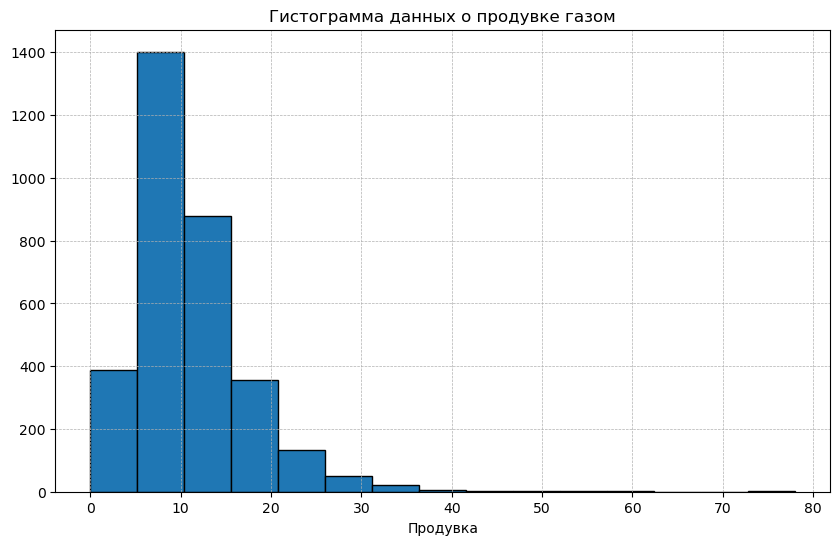

In [29]:
plt.figure(figsize=(10, 6))
data_gas['Газ 1'].hist(bins=15, edgecolor='black')
plt.xlabel('Продувка')
plt.title('Гистограмма данных о продувке газом')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

<b>Вывод по датафрейму</b>:
В данных отсутствуют пропуски и существенные аномалии - по всей видимости, можно будет использовать эту информацию без дополнительной обработки. 

### Результаты измерения температуры

In [30]:
try:
    data_temp = pd.read_csv('data_temp_new.csv')
except:
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')

In [31]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [32]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [33]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

print(data_temp.describe())

                key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000


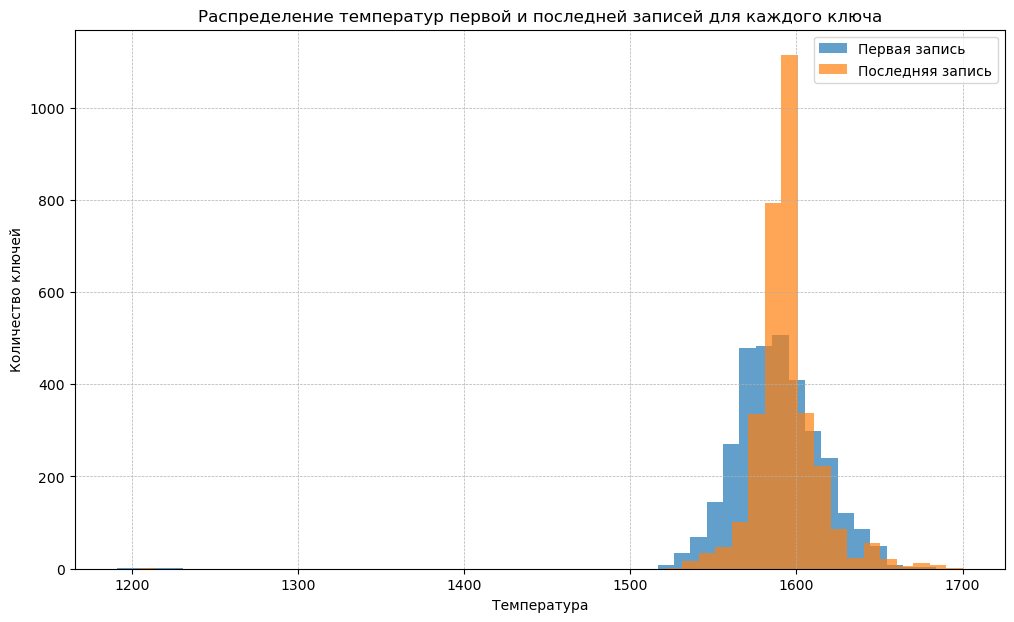

In [34]:
first_temps = data_temp.groupby('key')['Температура'].first()
last_temps = data_temp.groupby('key')['Температура'].last()

plt.figure(figsize=(12, 7))

# Гистограмма для первой записи
first_temps.hist(alpha=0.7, bins=50, label='Первая запись')

# Гистограмма для последней записи
last_temps.hist(alpha=0.7, bins=50, label='Последняя запись')

plt.xlabel('Температура')
plt.ylabel('Количество ключей')
plt.title('Распределение температур первой и последней записей для каждого ключа')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

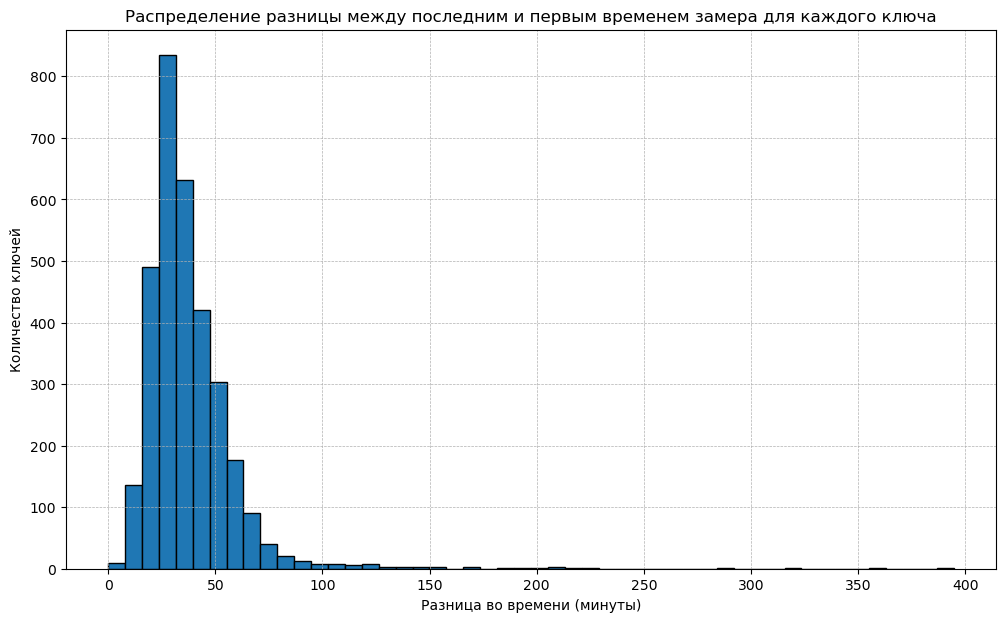

In [35]:
# Получим первое и последнее время замера для каждого ключа
first_times = data_temp.groupby('key')['Время замера'].first()
last_times = data_temp.groupby('key')['Время замера'].last()

# Вычислим разницу во времени и переведем ее в минуты
time_differences = (last_times - first_times).dt.total_seconds() / 60

plt.figure(figsize=(12, 7))

# Гистограмма разницы во времени
time_differences.hist(bins=50, edgecolor='black')

plt.xlabel('Разница во времени (минуты)')
plt.ylabel('Количество ключей')
plt.title('Распределение разницы между последним и первым временем замера для каждого ключа')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [36]:
# Подсчет количества строк для каждого уникального ключа
stages_count = data_temp.groupby('key').size()

# Описательная статистика
print(stages_count.describe())

count    3216.000000
mean        5.625622
std         1.612283
min         1.000000
25%         5.000000
50%         5.000000
75%         7.000000
max        17.000000
dtype: float64


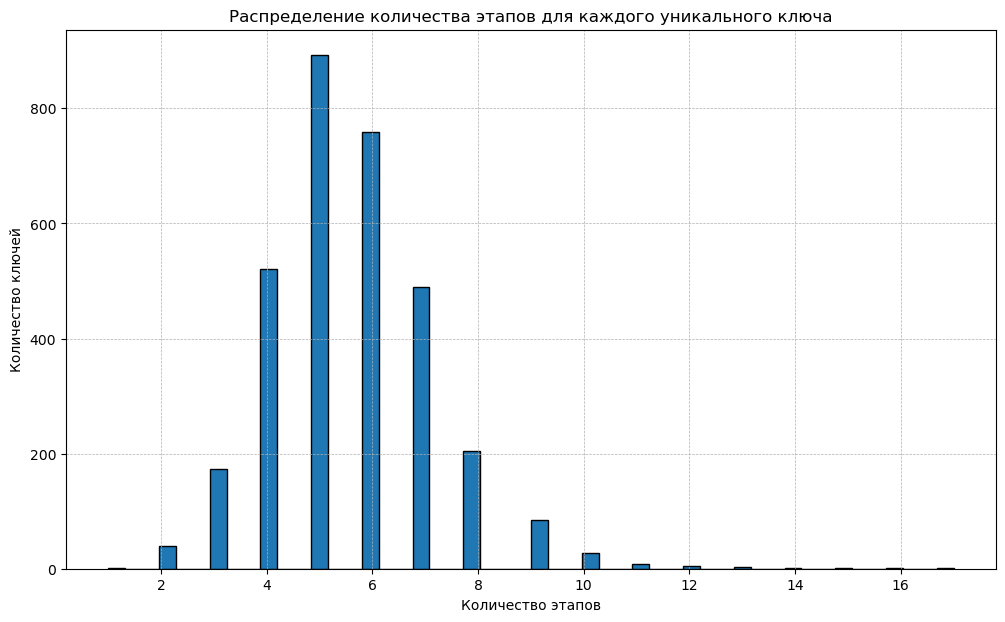

In [37]:
# Построение гистограммы
plt.figure(figsize=(12, 7))

stages_count.hist(bins=50, edgecolor='black')

plt.xlabel('Количество этапов')
plt.ylabel('Количество ключей')
plt.title('Распределение количества этапов для каждого уникального ключа')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

<b>Вывод по датафрейму</b>:
В целом, данные выглядят логично и не вызывают вопросов. Однако, перед обучением моделей необходимо провести работу по устранению пропусков и аномалий. 

### Выводы по разделу

Произведено первичное изучение данных, данные готовы к предобработке. 

## Предобработка данных

В данном разделе для каждого датафрейма произведем предобработку данных, разберемся с пропусками и аномальными значениями. Где это необходимо, выделим признаки. Целью раздела по каждому датафрейму является подготовка чистых данных, сгруппированных по ключу, для дальнейшего объединения их в единый датафрейм, где каждому процессу соответствует одна строка.

### Данные об электродах

In [38]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [39]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


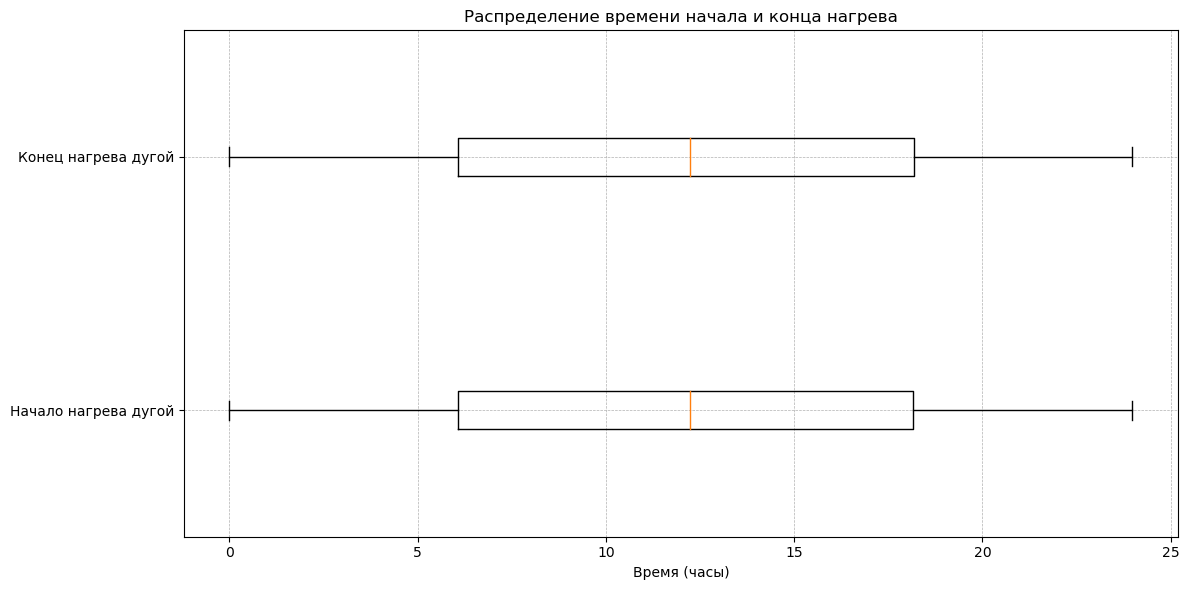

In [40]:
plt.figure(figsize=(12, 6))
plt.boxplot([data_arc['Начало нагрева дугой'].dt.hour + data_arc['Начало нагрева дугой'].dt.minute / 60,
             data_arc['Конец нагрева дугой'].dt.hour + data_arc['Конец нагрева дугой'].dt.minute / 60], 
            vert=False)
plt.yticks([1, 2], ['Начало нагрева дугой', 'Конец нагрева дугой'])
plt.xlabel('Время (часы)')
plt.title('Распределение времени начала и конца нагрева')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [41]:
# Удаляем данные по партиям, в которых есть отрицательная мощность
keys_to_remove = data_arc[data_arc['Реактивная мощность'] < 0]['key'].unique()
keys_to_remove

array([2116], dtype=int64)

In [42]:
data_arc = data_arc[~data_arc['key'].isin(keys_to_remove)]

In [43]:
print(data_arc.shape)
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]
data_arc.shape

(14872, 5)


(14872, 5)

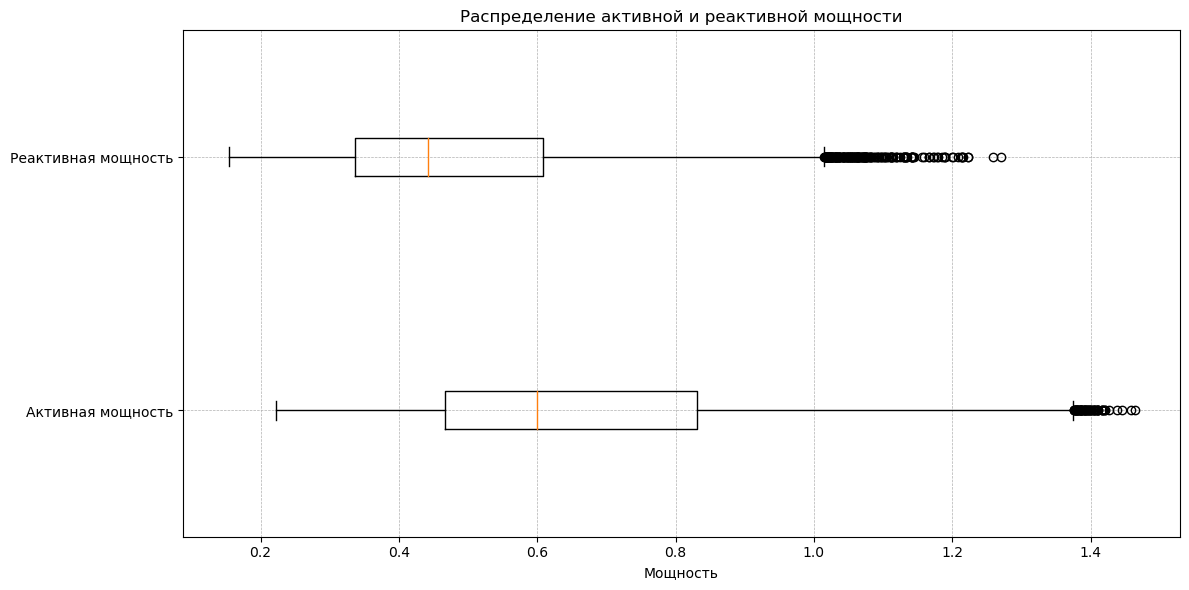

In [44]:
plt.figure(figsize=(12, 6))
plt.boxplot([data_arc['Активная мощность'], data_arc['Реактивная мощность']], vert=False)
plt.yticks([1, 2], ['Активная мощность', 'Реактивная мощность'])
plt.xlabel('Мощность')
plt.title('Распределение активной и реактивной мощности')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Выделим признак - общее время нагрева. С ним потом надо быть очень осторожным, по нему может быть утечка целевого признака. 

In [45]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds() / 60
data_arc['Время нагрева'] = data_arc['Время нагрева'].astype(int)
data_arc['Энергия'] = data_arc['Активная мощность']*data_arc['Время нагрева']
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
 5   Время нагрева         14872 non-null  int32         
 6   Энергия               14872 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int32(1), int64(1)
memory usage: 871.4 KB


In [46]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,3,0.915390
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,3,2.296974
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,2,1.160626
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,6,3.110976
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,2,1.734266


Сгруппируем данные по ключу со следующими столбцами: Общая активная мощность, Общая реактивная мощность, Общее энергия

In [47]:
data_arc_merged = data_arc.groupby('key').agg({
    'Активная мощность': 'sum',
    'Реактивная мощность': 'sum',
    'Энергия': 'sum'
}).reset_index()

# Переименовываем столбцы для удобства
data_arc_merged.columns = ['key', 'Общая активная мощность', 'Общая реактивная мощность', 'Общая энергия']
data_arc_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        3213 non-null   int64  
 1   Общая активная мощность    3213 non-null   float64
 2   Общая реактивная мощность  3213 non-null   float64
 3   Общая энергия              3213 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 100.5 KB


In [48]:
data_arc_merged.head()

,key,Общая активная мощность,Общая реактивная мощность,Общая энергия
0,1,3.036730,2.142821,9.218232
1,2,2.139408,1.453357,5.850133
2,3,4.063641,2.937457,7.911350
3,4,2.706489,2.056992,7.475221
4,5,2.252950,1.687991,6.108549


<b>Вывод по датафрейму</b>:
Выявленные аномалии в данных удалены, данные из датафрейма готовы к объединению. 

### Данные о подаче сыпучих материалов (объем)

In [49]:
data_bulk = data_bulk.fillna(0)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


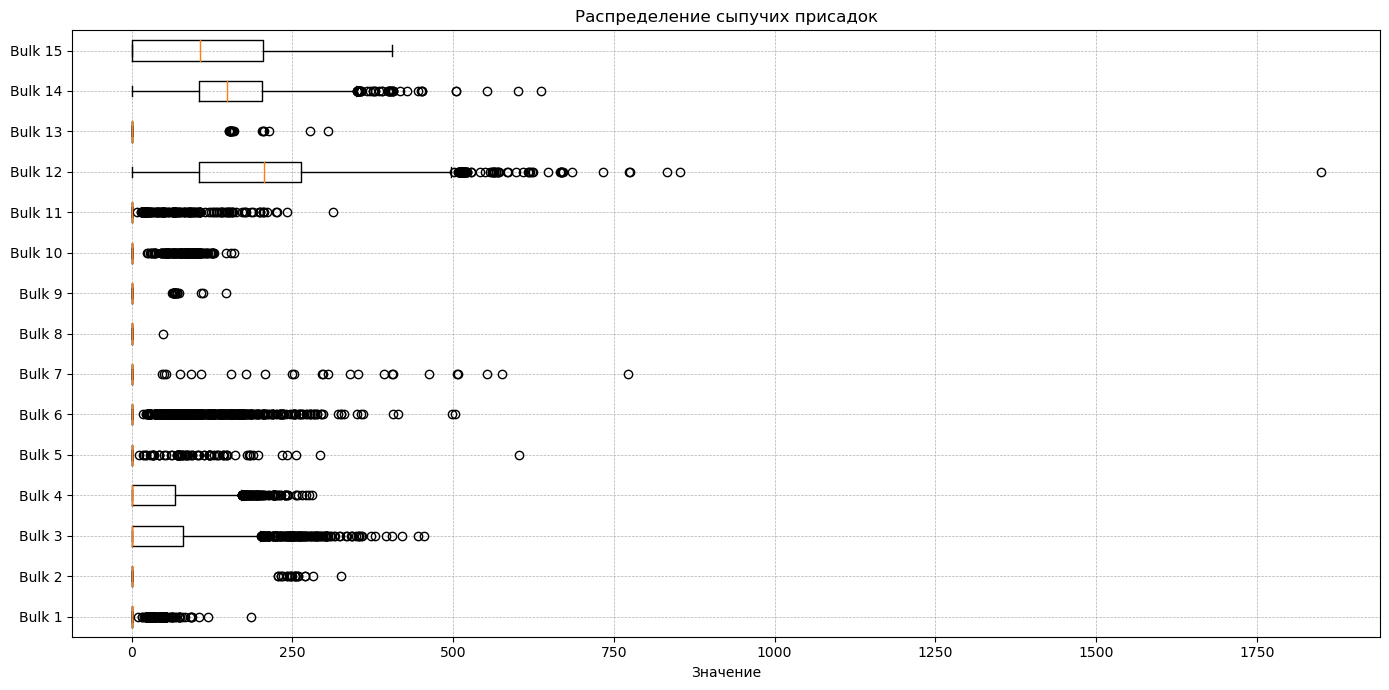

In [50]:
bulk_columns = data_bulk.columns[1:]

plt.figure(figsize=(14, 7))
plt.boxplot([data_bulk[col] for col in bulk_columns], vert=False)
plt.yticks(range(1, len(bulk_columns) + 1), bulk_columns)
plt.xlabel('Значение')
plt.title('Распределение сыпучих присадок')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Добавим два признака - общее количество присадок и общий объем всех присадок.

In [51]:
# Количество ненулевых значений для каждого key
data_bulk['Количество сыпучих присадок'] = data_bulk[bulk_columns].apply(lambda x: (x > 0).sum(), axis=1)

# Общий объем всех сыпучих присадок
data_bulk['Общий объем сыпучих присадок'] = data_bulk[bulk_columns].sum(axis=1)

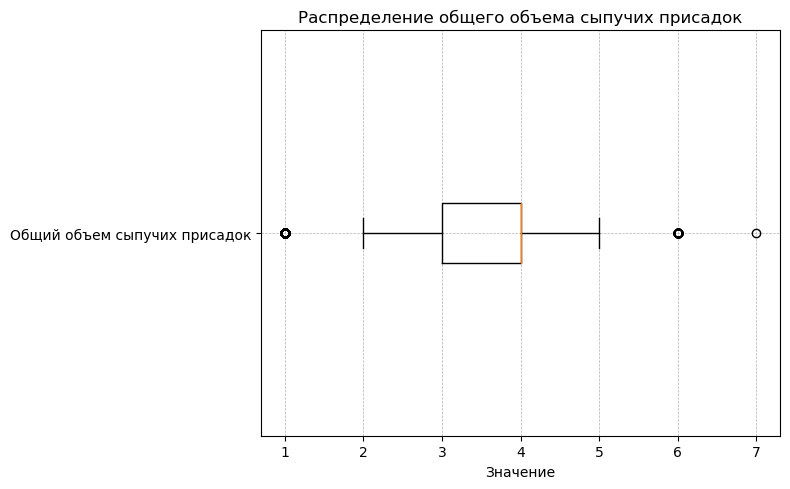

In [52]:
plt.figure(figsize=(8, 5))
plt.boxplot(data_bulk['Количество сыпучих присадок'], vert=False)
plt.yticks([1], ['Общий объем сыпучих присадок'])
plt.xlabel('Значение')
plt.title('Распределение общего объема сыпучих присадок')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

<b>Вывод по датафрейму</b>:
Существенных аномалий, требующих обработки, в данных не обнаружено. Добавлены два новых признака - общее количество сыпучих присадок и общий объем сыпучих присадок

### Данные о подаче проволочных материалов (объем)

In [53]:
data_wire = data_wire.fillna(0)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [54]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


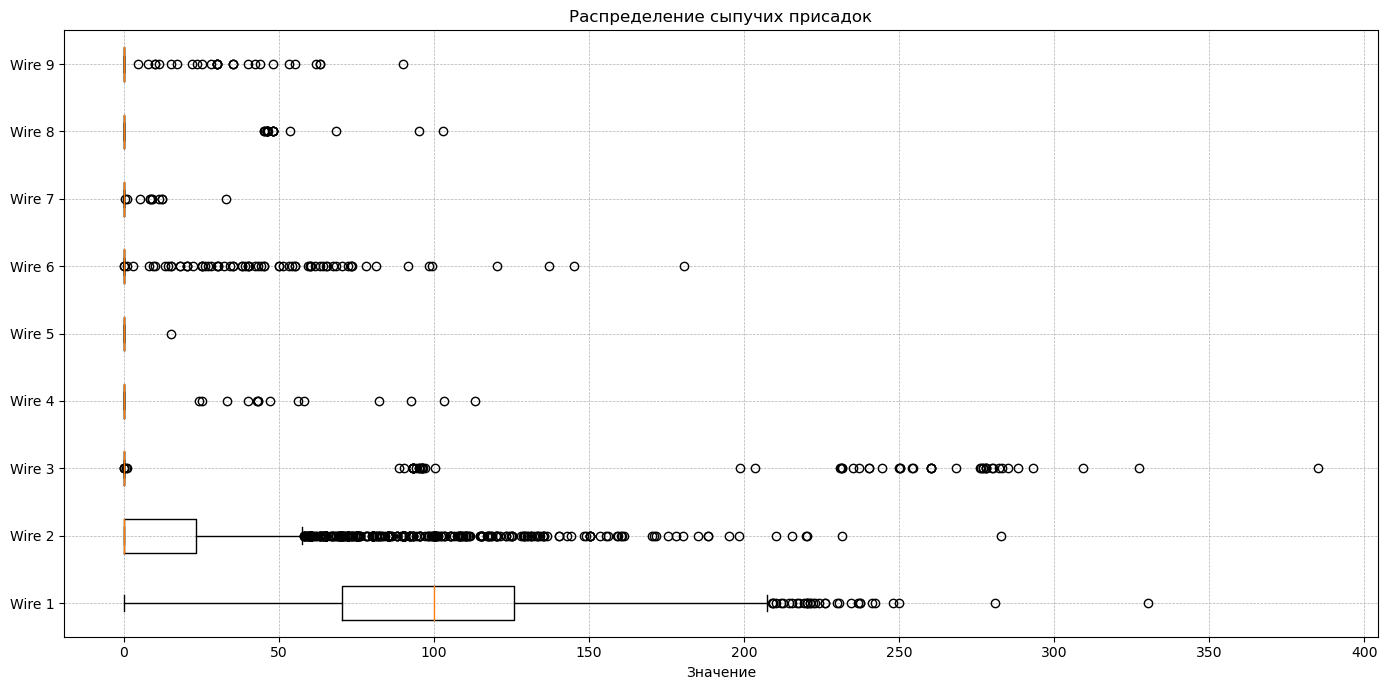

In [55]:
wire_columns = data_wire.columns[1:]

plt.figure(figsize=(14, 7))
plt.boxplot([data_wire[col] for col in wire_columns], vert=False)
plt.yticks(range(1, len(wire_columns) + 1), wire_columns)
plt.xlabel('Значение')
plt.title('Распределение сыпучих присадок')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [56]:
# Количество ненулевых значений для каждого key
data_wire['Количество проволочных присадок'] = data_wire[wire_columns].apply(lambda x: (x > 0).sum(), axis=1)

# Общий объем всех сыпучих присадок
data_wire['Общий объем проволочных присадок'] = data_wire[wire_columns].sum(axis=1)

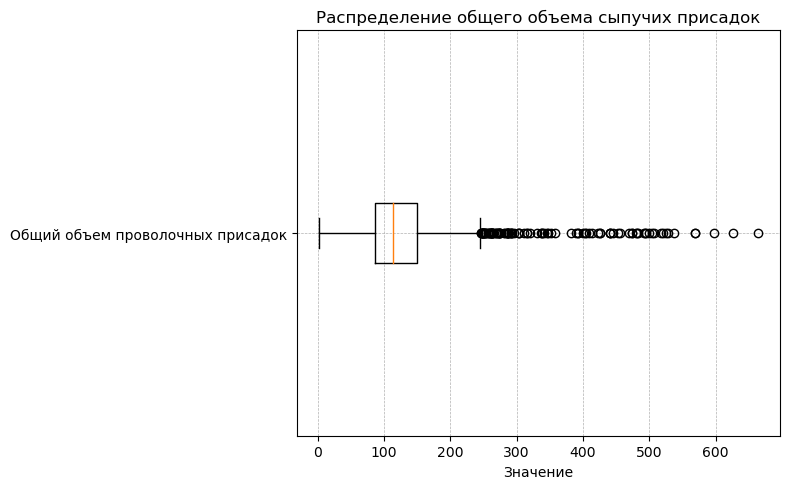

In [57]:
plt.figure(figsize=(8, 5))
plt.boxplot(data_wire['Общий объем проволочных присадок'], vert=False)
plt.yticks([1], ['Общий объем проволочных присадок'])
plt.xlabel('Значение')
plt.title('Распределение общего объема сыпучих присадок')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

<b>Вывод по датафрейму</b>:
Существенных аномалий, требующих обработки, в данных не обнаружено. Добавлены два новых признака - общее количество сыпучих присадок и общий объем проволочных присадок.

### Данные о продувке сплава газом

In [58]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [59]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


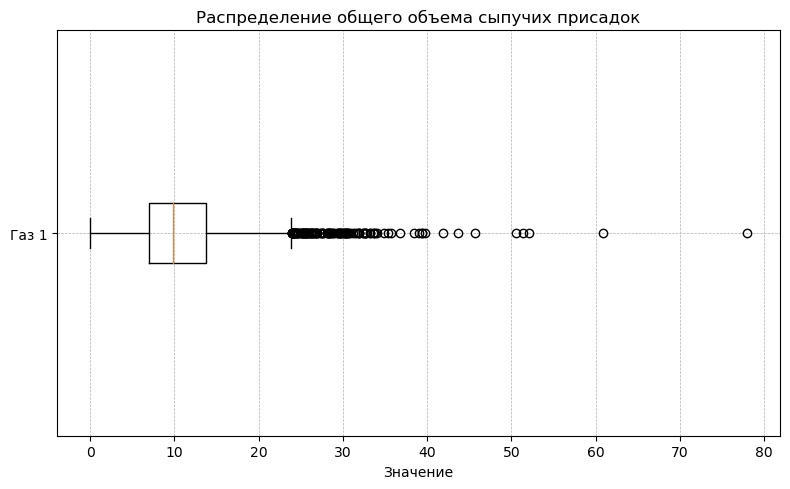

In [60]:
plt.figure(figsize=(8, 5))
plt.boxplot(data_gas['Газ 1'], vert=False)
plt.yticks([1], ['Газ 1'])
plt.xlabel('Значение')
plt.title('Распределение общего объема сыпучих присадок')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

<b>Вывод по датафрейму</b>:
Существенных аномалий, требующих обработки, в данных не обнаружено.

### Результаты измерения температуры

In [61]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [62]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Сначала удалим данные для партий, в которых только одно значение температуры. 

In [63]:
# Определение уникальных ключей с количеством значений равным 1
keys_with_single_value = data_temp['key'].value_counts()[data_temp['key'].value_counts() == 1].index

print('Процессов с одним замером температуры', len(keys_with_single_value))

# Удаление строк с ключами, имеющими только 1 значение
data_temp = data_temp[~data_temp['key'].isin(keys_with_single_value)]

Процессов с одним замером температуры 2


Удалим строки с неразумно низкой начальной температурой.

In [64]:
keys_to_remove = data_temp[data_temp['Температура'] < 1300]['key'].unique()
keys_to_remove

array([ 867, 1214, 1619, 2052, 2561], dtype=int64)

In [65]:
data_temp = data_temp[~data_temp['key'].isin(keys_to_remove)]

In [66]:
keys_nan = data_temp[data_temp['Температура'].isna()]['key'].unique()
len(keys_nan)

738

In [67]:
data_temp = data_temp[~data_temp['key'].isin(keys_nan)]

In [68]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13903 non-null  int64         
 1   Время замера  13903 non-null  datetime64[ns]
 2   Температура   13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


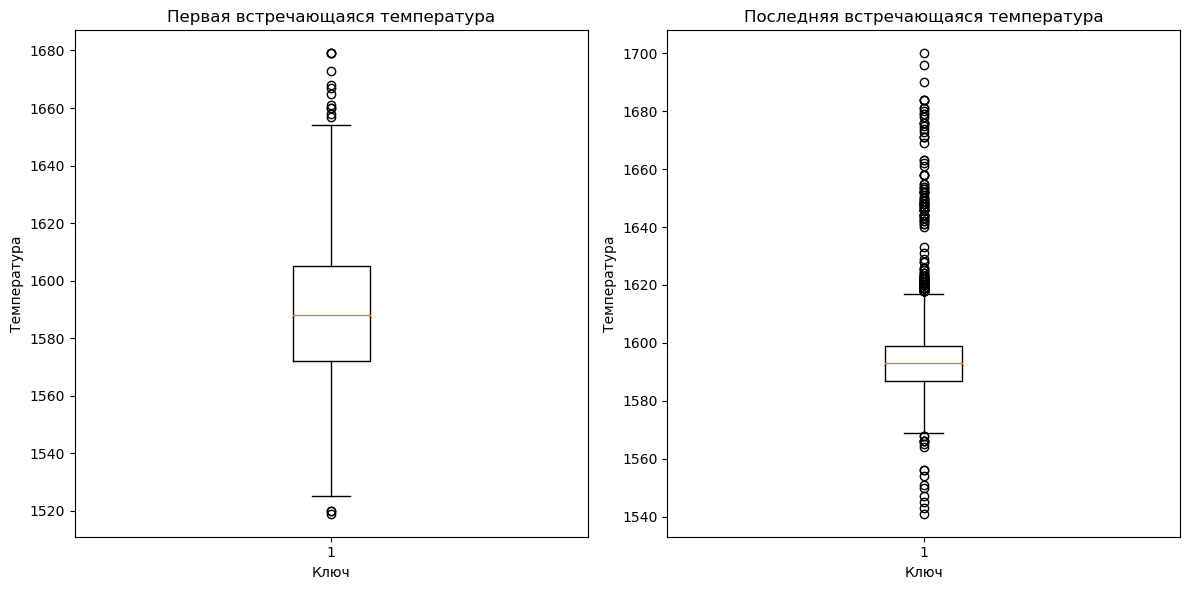

In [69]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

# Сортируем данные по времени замера
data_temp = data_temp.sort_values(by=['key', 'Время замера'])

# Группируем и берем первую и последнюю температуру для каждого ключа
first_temps = data_temp.groupby('key')['Температура'].first()
last_temps = data_temp.groupby('key')['Температура'].last()

# Создаем боксплоты
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(first_temps.dropna())  # Удаляем NaN значения
plt.title('Первая встречающаяся температура')
plt.xlabel('Ключ')
plt.ylabel('Температура')

plt.subplot(1, 2, 2)
plt.boxplot(last_temps.dropna())  # Удаляем NaN значения
plt.title('Последняя встречающаяся температура')
plt.xlabel('Ключ')
plt.ylabel('Температура')

plt.tight_layout()
plt.show()

In [70]:
# Сортируем данные по времени замера
data_temp = data_temp.sort_values(by=['key', 'Время замера'])

# Группируем по ключу и выполняем агрегацию
data_temp_grouped = data_temp.groupby('key').agg({
    'Температура': ['first', 'last', 'size'],
    'Время замера': lambda x: (x.max() - x.min()).total_seconds()
})

# Переименовываем столбцы для удобства
data_temp_grouped.columns = ['первая_температура', 'последняя_температура', 'количество_температур', 'время_между_этапами']

# Выводим результат
data_temp_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   первая_температура     2471 non-null   float64
 1   последняя_температура  2471 non-null   float64
 2   количество_температур  2471 non-null   int64  
 3   время_между_этапами    2471 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 96.5 KB


In [71]:
data_temp_grouped.head()

,первая_температура,последняя_температура,количество_температур,время_между_этапами
key,,,,
1,1571.0,1613.0,6,1714.0
2,1581.0,1602.0,5,1265.0
3,1596.0,1599.0,6,1753.0
4,1601.0,1625.0,5,1220.0
5,1576.0,1602.0,5,1536.0


<b>Вывод по датафрейму</b>:
Данные готовы к объединенияю. 

## Формируем общий датафрейм. 

Объединяем все подготовленные датафреймы. 

In [72]:
merged_data = data_temp_grouped.merge(data_gas, on='key', how='inner') \
                                .merge(data_wire, on='key', how='inner') \
                                .merge(data_bulk, on='key', how='inner') \
                                .merge(data_arc_merged, on='key', how='inner')

In [73]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   key                               2324 non-null   int64  
 1   первая_температура                2324 non-null   float64
 2   последняя_температура             2324 non-null   float64
 3   количество_температур             2324 non-null   int64  
 4   время_между_этапами               2324 non-null   float64
 5   Газ 1                             2324 non-null   float64
 6   Wire 1                            2324 non-null   float64
 7   Wire 2                            2324 non-null   float64
 8   Wire 3                            2324 non-null   float64
 9   Wire 4                            2324 non-null   float64
 10  Wire 5                            2324 non-null   float64
 11  Wire 6                            2324 non-null   float64
 12  Wire 7

In [74]:
merged_data.head()

,key,первая_температура,последняя_температура,количество_температур,время_между_этапами,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Количество сыпучих присадок,Общий объем сыпучих присадок,Общая активная мощность,Общая реактивная мощность,Общая энергия
0,1,1571.0,1613.0,6,1714.0,29.749986,60.059998,0.00000,0.0,0.0,...,0.0,206.0,0.0,150.0,154.0,4,553.0,3.036730,2.142821,9.218232
1,2,1581.0,1602.0,5,1265.0,12.555561,96.052315,0.00000,0.0,0.0,...,0.0,206.0,0.0,149.0,154.0,4,582.0,2.139408,1.453357,5.850133
2,3,1596.0,1599.0,6,1753.0,28.554793,91.160157,0.00000,0.0,0.0,...,0.0,205.0,0.0,152.0,153.0,4,544.0,4.063641,2.937457,7.911350
3,4,1601.0,1625.0,5,1220.0,18.841219,89.063515,0.00000,0.0,0.0,...,0.0,207.0,0.0,153.0,154.0,4,595.0,2.706489,2.056992,7.475221
4,5,1576.0,1602.0,5,1536.0,5.413692,89.238236,9.11456,0.0,0.0,...,0.0,203.0,0.0,151.0,152.0,4,584.0,2.252950,1.687991,6.108549


Посмотрим корреляцию данных - не будем смотреть каждую отдельную присадку, только общие значения, по которым могла произойти утечка. 

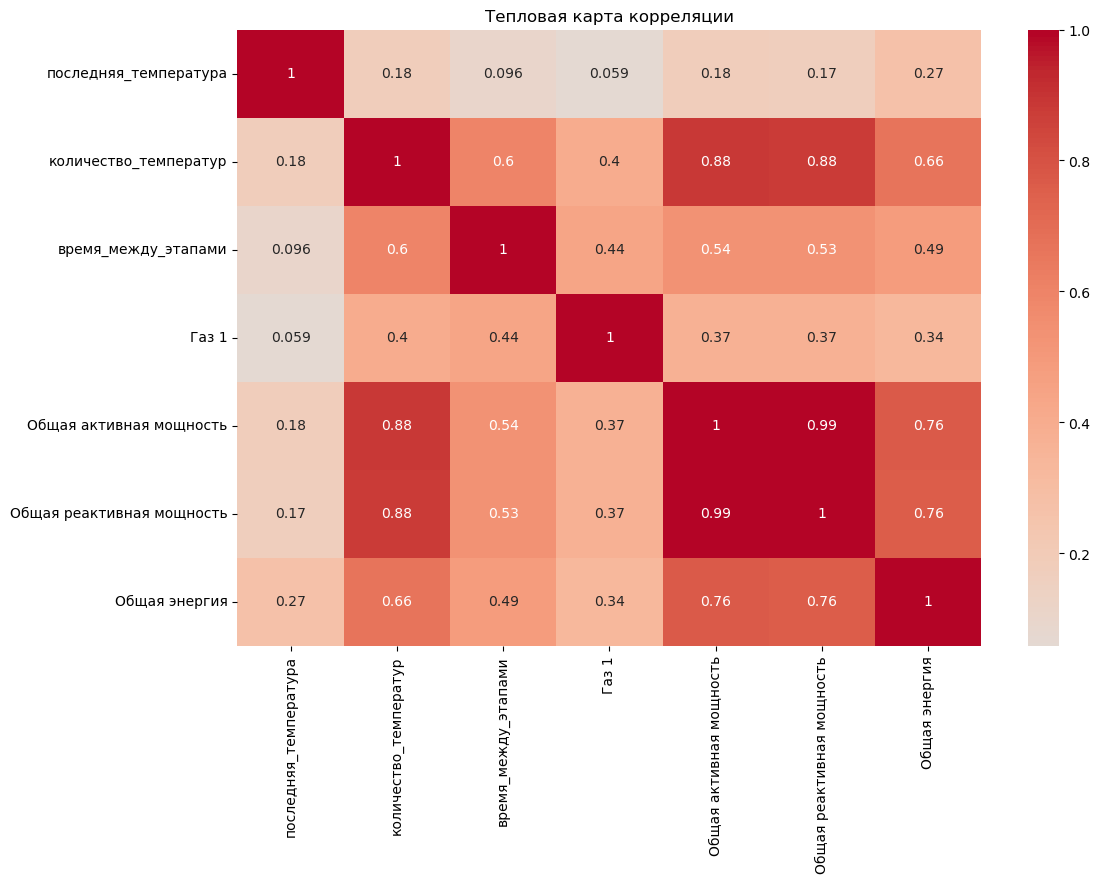

In [75]:
columns_for_correlation = ['последняя_температура', 'количество_температур',
    'время_между_этапами', 'Газ 1', 'Общая активная мощность', 'Общая реактивная мощность', 'Общая энергия',
    ]

# Вычисляем корреляцию между выбранными значениями столбцов
correlation_matrix = merged_data[columns_for_correlation].corr()

# Создаем тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Тепловая карта корреляции')
plt.show()

Выводы по корреляции: 

1. Активная мощность, реактивная мощность, время и энергия сильно коррелируют. 
2. В остальном, судя по карте для целевого признака, утечки не происходит. 

In [76]:
columns_to_drop = ['Общая реактивная мощность', 'Общая активная мощность', 'количество_температур', 'время_между_этапами']
merged_data = merged_data.drop(columns=columns_to_drop)

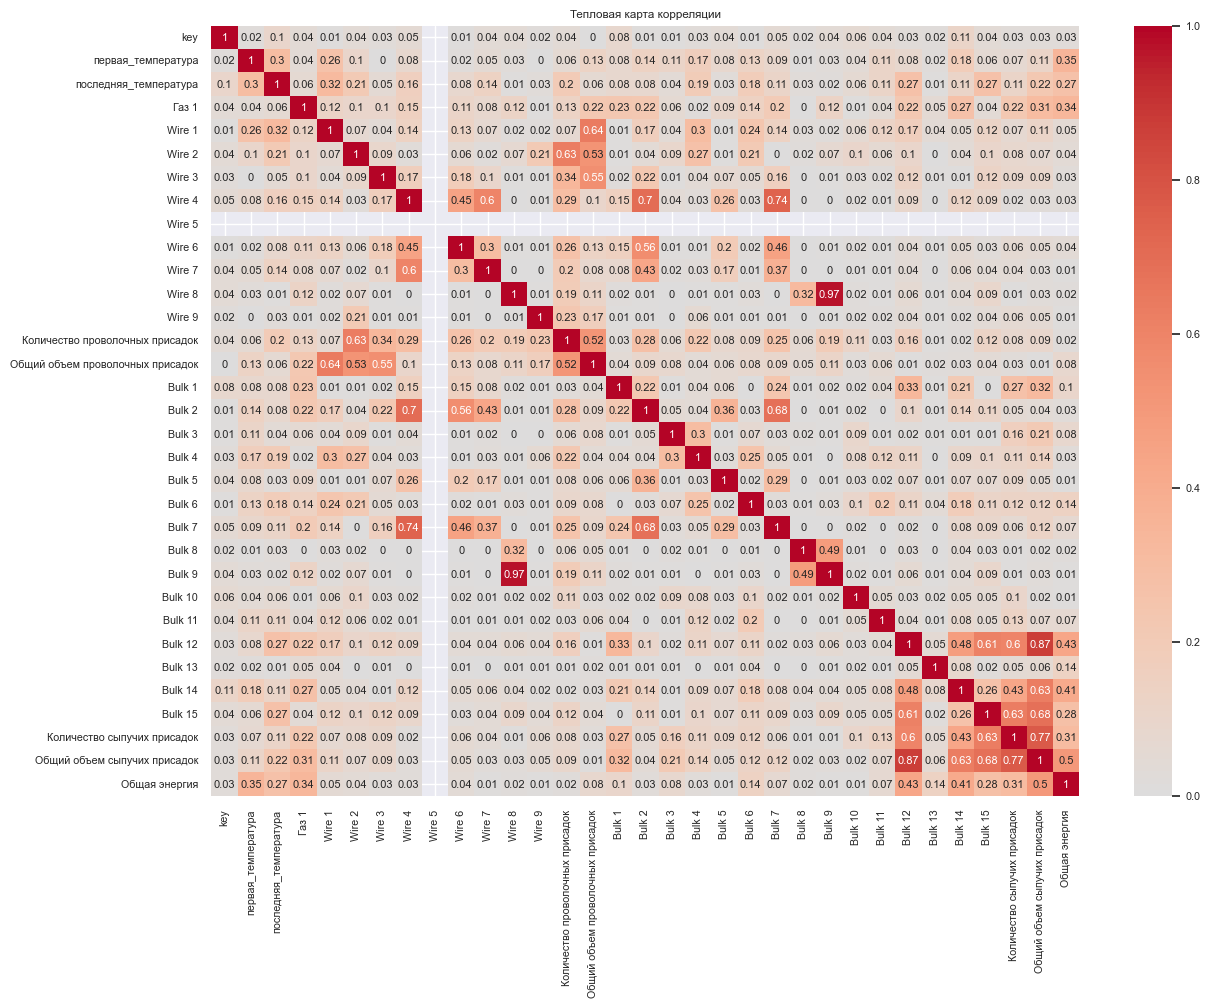

In [77]:
correlation_matrix = merged_data.corr()

# Создаем тепловую карту
plt.figure(figsize=(14, 10))
# Используем абсолютные значения корреляции
corr_abs = correlation_matrix.abs()
# Ограничиваем количество знаков до двух
corr_rounded = corr_abs.round(2)
# Устанавливаем шрифт размером 7
sns.set(font_scale=0.7)
sns.heatmap(corr_rounded, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 8})
plt.title('Тепловая карта корреляции')
plt.show()

Есть несколько удивительных корреляций - например, bulk_9 почти всегда добавляют вместе с Wire_8. Учитывая, что модель уже хорошо обучается и метрика соответствует ТЗ, признаки удалять не будем, но в целом, виден потенциал для улучшения модели. 

In [78]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   key                               2324 non-null   int64  
 1   первая_температура                2324 non-null   float64
 2   последняя_температура             2324 non-null   float64
 3   Газ 1                             2324 non-null   float64
 4   Wire 1                            2324 non-null   float64
 5   Wire 2                            2324 non-null   float64
 6   Wire 3                            2324 non-null   float64
 7   Wire 4                            2324 non-null   float64
 8   Wire 5                            2324 non-null   float64
 9   Wire 6                            2324 non-null   float64
 10  Wire 7                            2324 non-null   float64
 11  Wire 8                            2324 non-null   float64
 12  Wire 9

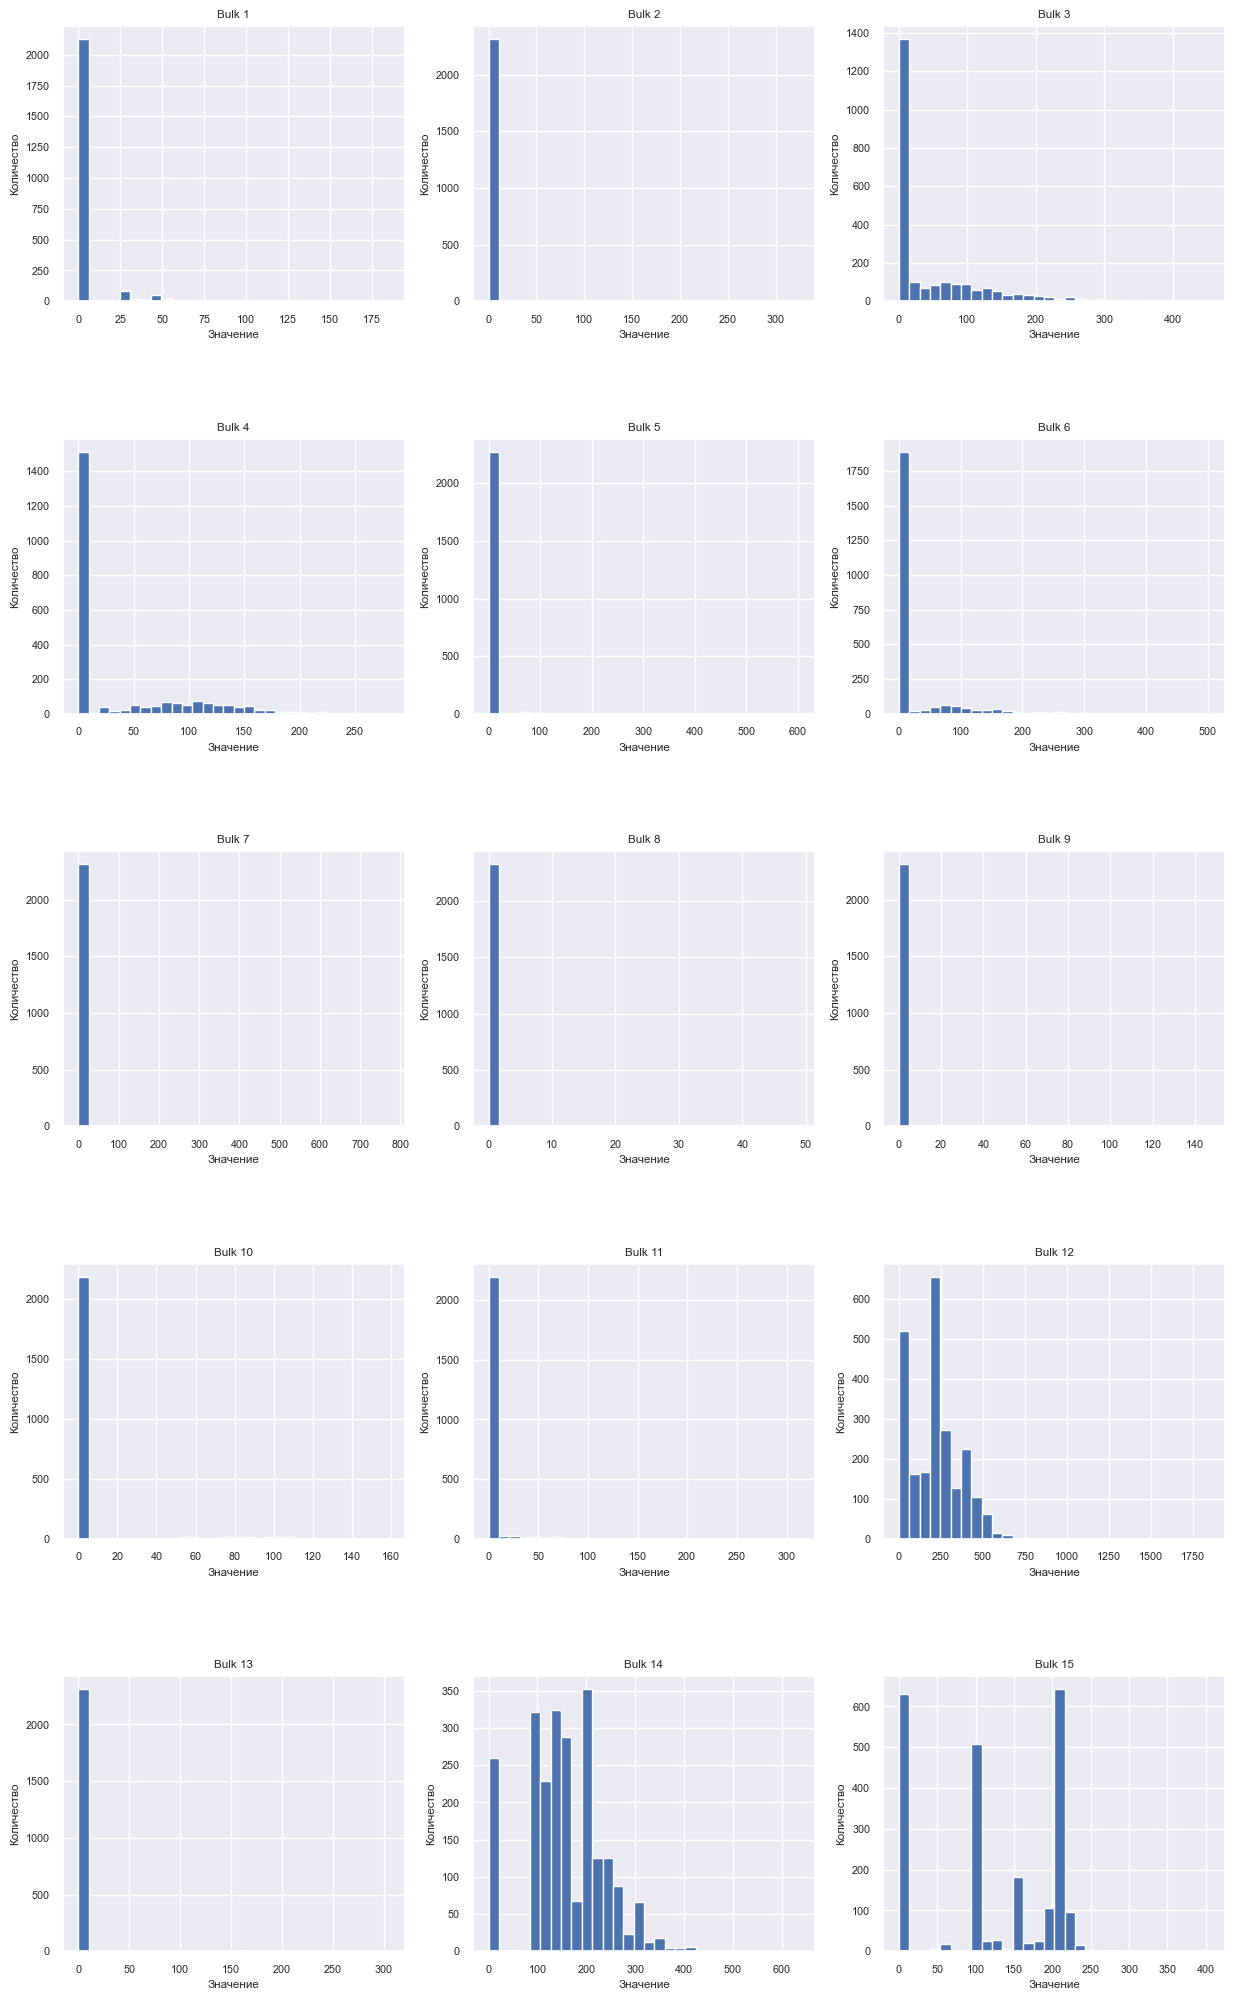

In [79]:
# Выбираем столбцы с данными по 'Bulk'
bulk_columns = [col for col in merged_data.columns if col.startswith('Bulk')]

# Задаем решетку для гистограмм
n_cols = 3
n_rows = (len(bulk_columns) + n_cols - 1) // n_cols

# Создаем subplots 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 5))
plt.subplots_adjust(hspace=0.5)

# Строим гистограммы
for col, ax in zip(bulk_columns, axes.flatten()):
    merged_data[col].hist(bins=30, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Значение')
    ax.set_ylabel('Количество')

# Remove any unused subplots
for i in range(len(bulk_columns), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.show()

In [80]:
bulks_to_drop = ['Bulk 2', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13']
merged_data = merged_data.drop(bulks_to_drop, axis=1)

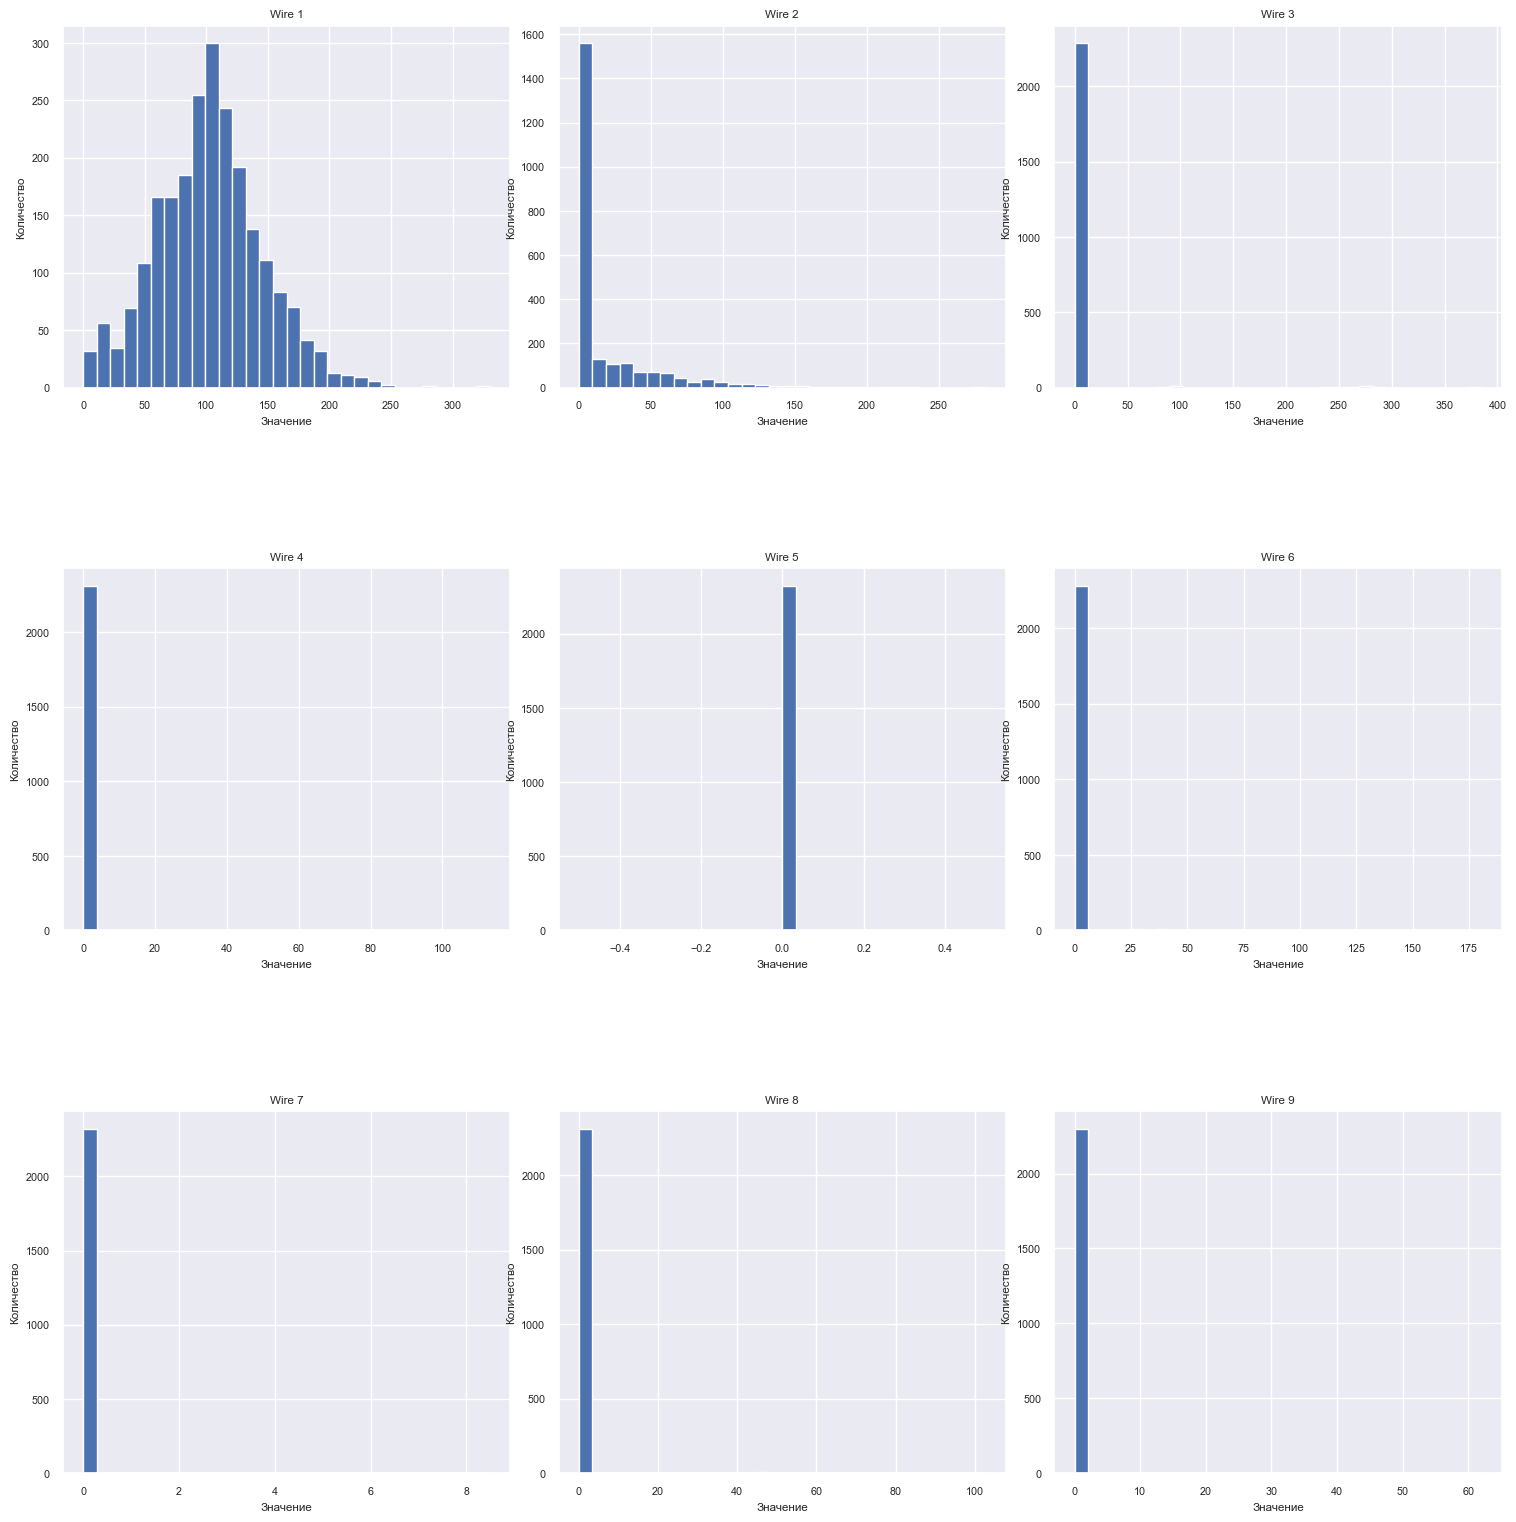

In [81]:
wire_columns = [col for col in merged_data.columns if col.startswith('Wire')]

# Calculate the number of rows needed
n_cols = 3
n_rows = (len(wire_columns) + n_cols - 1) // n_cols

# Create subplots with the calculated number of rows and columns
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 5))
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

# Plot histograms for each 'Wire' column
for col, ax in zip(wire_columns, axes.flatten()):
    merged_data[col].hist(bins=30, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Значение')
    ax.set_ylabel('Количество')

# Remove any unused subplots
for i in range(len(wire_columns), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

plt.show()

In [82]:
wires_to_drop = ['Wire 3', 'Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Wire 9']
merged_data = merged_data.drop(wires_to_drop, axis=1)

In [83]:
merged_data.head()

,key,первая_температура,последняя_температура,Газ 1,Wire 1,Wire 2,Wire 6,Количество проволочных присадок,Общий объем проволочных присадок,Bulk 1,...,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Количество сыпучих присадок,Общий объем сыпучих присадок,Общая энергия
0,1,1571.0,1613.0,29.749986,60.059998,0.00000,0.0,1,60.059998,0.0,...,0.0,0.0,0.0,0.0,206.0,150.0,154.0,4,553.0,9.218232
1,2,1581.0,1602.0,12.555561,96.052315,0.00000,0.0,1,96.052315,0.0,...,0.0,0.0,0.0,0.0,206.0,149.0,154.0,4,582.0,5.850133
2,3,1596.0,1599.0,28.554793,91.160157,0.00000,0.0,1,91.160157,0.0,...,0.0,0.0,0.0,0.0,205.0,152.0,153.0,4,544.0,7.911350
3,4,1601.0,1625.0,18.841219,89.063515,0.00000,0.0,1,89.063515,0.0,...,0.0,0.0,0.0,0.0,207.0,153.0,154.0,4,595.0,7.475221
4,5,1576.0,1602.0,5.413692,89.238236,9.11456,0.0,2,98.352796,0.0,...,0.0,0.0,0.0,0.0,203.0,151.0,152.0,4,584.0,6.108549


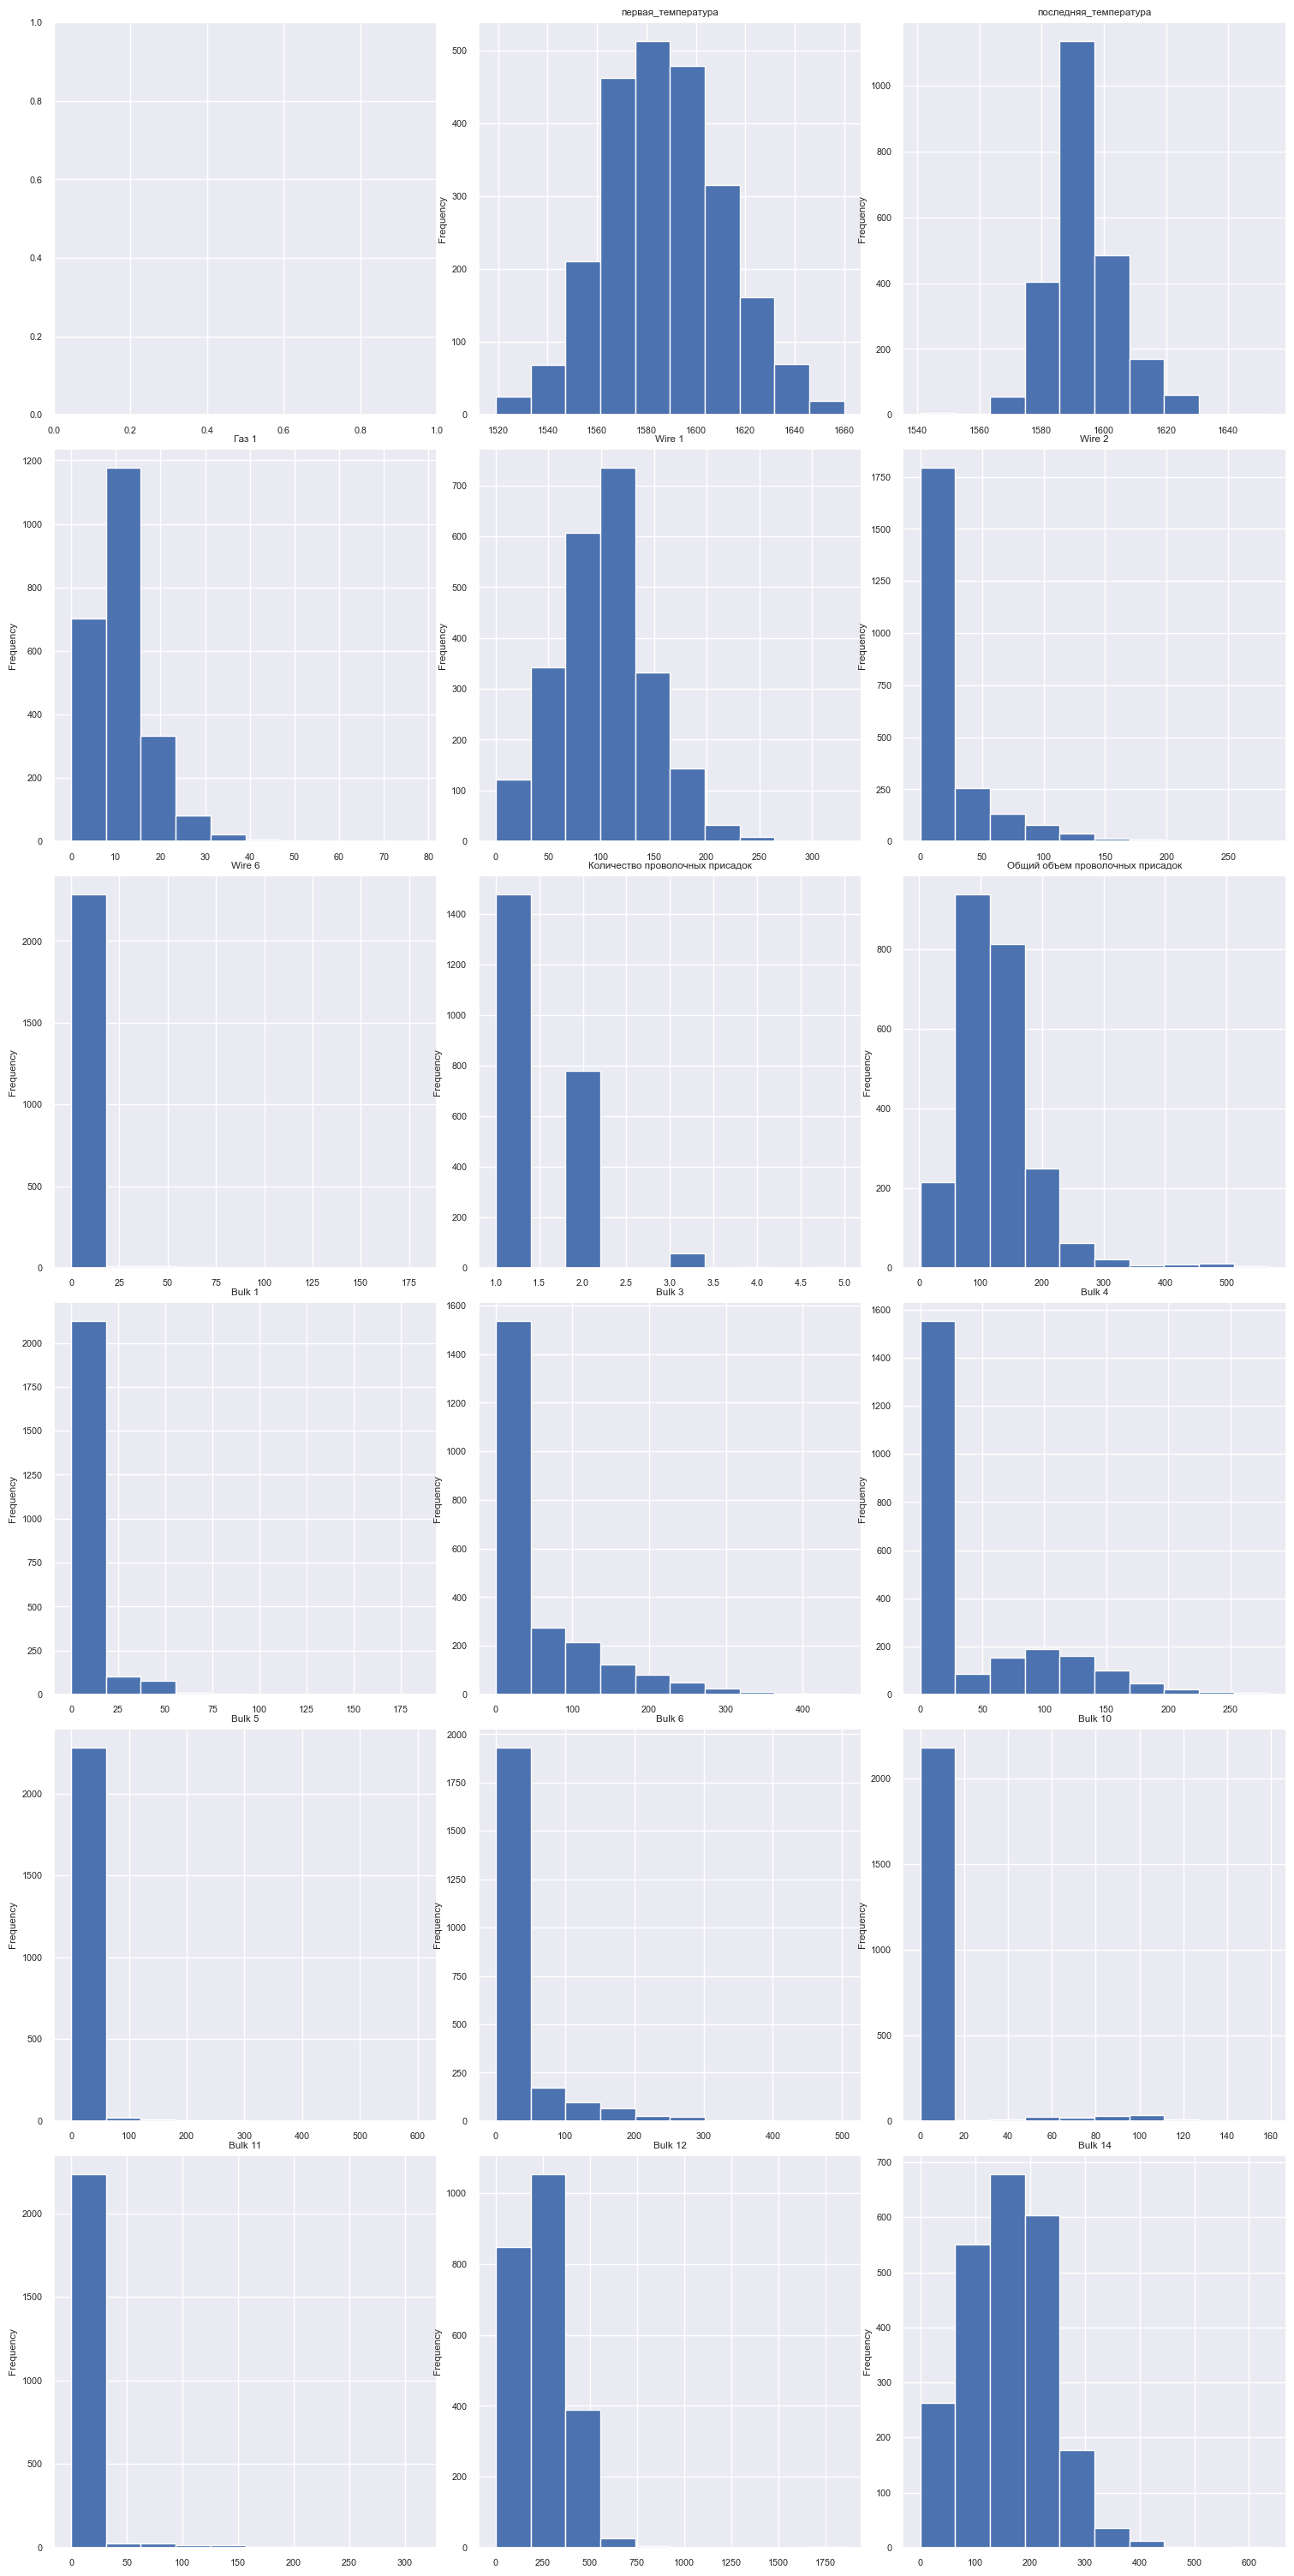

In [84]:
# Создание сетки графиков
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 30))
plt.tight_layout()

# Построение графиков для каждого столбца данных
for col, ax in zip(merged_data.columns, axes.flatten()):
    if col != 'key':
        merged_data[col].plot(kind='hist', ax=ax)
        ax.set_title(col)
plt.show()

In [85]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   key                               2324 non-null   int64  
 1   первая_температура                2324 non-null   float64
 2   последняя_температура             2324 non-null   float64
 3   Газ 1                             2324 non-null   float64
 4   Wire 1                            2324 non-null   float64
 5   Wire 2                            2324 non-null   float64
 6   Wire 6                            2324 non-null   float64
 7   Количество проволочных присадок   2324 non-null   int64  
 8   Общий объем проволочных присадок  2324 non-null   float64
 9   Bulk 1                            2324 non-null   float64
 10  Bulk 3                            2324 non-null   float64
 11  Bulk 4                            2324 non-null   float64
 12  Bulk 5

### Вывод по разделу
Данные сведены в одну общую таблицу, где каждой записи соответствует один процесс варки стали. Данные готовы к подготовке признаков. 

## Подготовка признаков

In [86]:
# Выделение признаков (все столбцы, кроме 'key' и 'последняя_температура')
features = merged_data.drop(['key', 'последняя_температура'], axis=1)

# Выделение целевого признака ('последняя_температура')
target = merged_data['последняя_температура']

print("Features:", features.shape)
print("Target:", target.shape)

Features: (2324, 20)
Target: (2324,)


In [87]:
features.head()

,первая_температура,Газ 1,Wire 1,Wire 2,Wire 6,Количество проволочных присадок,Общий объем проволочных присадок,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Количество сыпучих присадок,Общий объем сыпучих присадок,Общая энергия
0,1571.0,29.749986,60.059998,0.00000,0.0,1,60.059998,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,4,553.0,9.218232
1,1581.0,12.555561,96.052315,0.00000,0.0,1,96.052315,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,4,582.0,5.850133
2,1596.0,28.554793,91.160157,0.00000,0.0,1,91.160157,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,4,544.0,7.911350
3,1601.0,18.841219,89.063515,0.00000,0.0,1,89.063515,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,4,595.0,7.475221
4,1576.0,5.413692,89.238236,9.11456,0.0,2,98.352796,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,4,584.0,6.108549


In [88]:
target.head()

0    1613.0
1    1602.0
2    1599.0
3    1625.0
4    1602.0
Name: последняя_температура, dtype: float64

In [89]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=140823)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (1743, 20)
X_test: (581, 20)
y_train: (1743,)
y_test: (581,)


Раньше здесь было масштабирование данных. Однако, при таком масштабировании метрика на линейной регрессии улетает почти в бесконечность, а на двух других просто не улучшается. 

In [90]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Вывод по разделу
Признаки отмасштабированы, модели готовы к обучению. 

## Обучение моделей

### Линейная регрессия

In [91]:
model_lr = LinearRegression()
scores_lr = cross_val_score(model_lr, X_train_scaled, y_train, cv=3, scoring='neg_mean_absolute_error')
mae_lr = - scores_lr.mean()
print("Линейная регрессия MAE:", mae_lr)

Линейная регрессия MAE: 6.543093065752605


### Случайный лес

In [92]:
model_rf = RandomForestRegressor(random_state=140823)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search_rf = RandomizedSearchCV(
    model_rf, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_absolute_error', random_state=140823)
random_search_rf.fit(X_train_scaled, y_train)
mae_rf = -random_search_rf.best_score_

# Вывод лучших параметров
best_params_rf = random_search_rf.best_params_
print("Лучшие параметры случайного леса:", best_params_rf)
print("Случайный лес MAE:", mae_rf)

Лучшие параметры случайного леса: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30}
Случайный лес MAE: 6.48030167974207


### CatBoost

In [93]:
param_dist = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}


catboost = CatBoostRegressor(loss_function='MAE', verbose=0, random_state=140823)


random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error',  # Минимизация MAE
    n_iter=10,  # Количество итераций поиска
    cv=3,  # Количество фолдов в кросс-валидации
    random_state=140823,
    verbose=2
)

# Поиск по параметрам
random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучшее значение MAE:", -random_search.best_score_)  

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END depth=6, iterations=200, l2_leaf_reg=3, learning_rate=0.2; total time=   0.7s
[CV] END depth=6, iterations=200, l2_leaf_reg=3, learning_rate=0.2; total time=   0.8s
[CV] END depth=6, iterations=200, l2_leaf_reg=3, learning_rate=0.2; total time=   0.8s
[CV] END depth=8, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.1s
[CV] END depth=8, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.1s
[CV] END depth=8, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   1.1s
[CV] END depth=10, iterations=300, l2_leaf_reg=3, learning_rate=0.2; total time=  14.9s
[CV] END depth=10, iterations=300, l2_leaf_reg=3, learning_rate=0.2; total time=  15.3s
[CV] END depth=10, iterations=300, l2_leaf_reg=3, learning_rate=0.2; total time=  16.0s
[CV] END depth=6, iterations=200, l2_leaf_reg=9, learning_rate=0.1; total time=   0.8s
[CV] END depth=6, iterations=200, l2_leaf_reg=9, learning_rate=

<b>Вывод по разделу</b>

Проведено обучение трех модель - линейной регрессии, случайного леса и CatBoost. Для двух последних моделей проведена оптимизация параметров. Наилучший результат на тренировочной выборке показала модель Catboost. 

## Проверка на тестовой выборке

### Референсные модели

#### Константная модель

In [94]:
y_train_mean = np.mean(y_train)  

y_pred = np.full(y_test.shape, y_train_mean)

In [95]:
print('MAE на тестовой выборке для константной модели:', mean_absolute_error(y_test, y_pred))

MAE на тестовой выборке для константной модели: 8.683844796446664


## Catboost

In [96]:
y_pred = random_search_rf.best_estimator_.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
print("MAE на тестовой выборке:", mae)

MAE на тестовой выборке: 6.776325675461495


In [97]:
feature_importance = random_search_rf.best_estimator_.feature_importances_

# Создаем DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({'Признак': X_train.columns, 'Важность': feature_importance})

# Сортируем по важности в убывающем порядке
feature_importance_df = feature_importance_df.sort_values(by='Важность', ascending=False)

print("Важность признаков:")
print(feature_importance_df)

Важность признаков:
                             Признак  Важность
0                 первая_температура  0.202033
19                     Общая энергия  0.200587
2                             Wire 1  0.105287
11                            Bulk 6  0.064933
1                              Газ 1  0.064433
16                           Bulk 15  0.060649
3                             Wire 2  0.052477
15                           Bulk 14  0.046985
18      Общий объем сыпучих присадок  0.043154
6   Общий объем проволочных присадок  0.042264
14                           Bulk 12  0.036296
8                             Bulk 3  0.019324
9                             Bulk 4  0.017397
4                             Wire 6  0.015803
17       Количество сыпучих присадок  0.010644
7                             Bulk 1  0.009522
5    Количество проволочных присадок  0.003308
13                           Bulk 11  0.002036
10                            Bulk 5  0.001801
12                           Bulk 10  0.

Начальная температура и общая затраченная в процессе энергия оказались наиболее важными признаками для прогнозирования целевой переменной. Некоторые признаки связанные с добавками также имеют существенное влияние на модель, но их важность ниже по сравнению с температурой и энергией. 

<b>Вывод по разделу</b>

Работа модели на тестовой выборке позволяет получать предсказание со значением метрики, укладывающейся в ТЗ. Это значение существенно лучше, чем метрика при использовании константной модели. 

# Отчет

## Оценка плана работ
Ниже приведен утвержденный план работ, которым руководствовались в ходе выолнения проетка:

1. Загрузка и обзор данных - выполнено

2. Подготовка данных

    2.1. Обработка аномалий и пропусков по каждому датафрейму
    
    2.2. Формирование нового объединяющего датафрейма
    
    2.3. Выявление параметров модели в общем датафрейме
  
    
3. Обучение моделей

    3.1. Раздаление на тренировочную и тестовые выборки
    
    3.2. Обучение моделей
    
    3.3. Анализ, выявление наиболее эффективной модели
    
    3.4. Проверка модели на тестовой выборке
    
    
4. Общие выводы

В целом, план адекватен поставленным задачам и его выполнение позволило достичь целей работы. Тем не менее, из недостатков планирования работы стоит отметить отсутствие в плане "обратной связи" - после пункта 3.3. необходим еще один пункт "Дополнительная работа с данными, улучшение признаков". Именно так развивался проект: после анализа моделей стало очевидно, что необходима дополнительная работа с признаками, которая была проведена при поддержке тимлида. 

## Трудности и особенности проекта 

Можно определить две основных сложности проекта: агрегация данных по процессам и сведение данных из разных датафреймов в одну общую таблицу. 
Исходные таблицы можно разделить на две группы: данные, в которых каждому процессу (уникальному ключу, key) соответствует одна строка с данными и таблицы, где для каждого процесса присутствует несколько строк с данными. Последние - данные по электродам и данные по температуре - необходимо агрегировать так, чтобы каждому ключу соответствовала одна строка данных. При агрегации данных необходимо учитывать, что неадекватные данные на любом из этапов процесса должны приводить к исключению из анализа всего процесса целиком, а не только проблемного этапа. Также, необходимо аккуратно выбирать функции для агрегации: при наличии в процессе нескольких этапов, необходимо рассчитывать время и энергию по каждому этапу, после чего суммировать эти значения при агрегации данных по процессу. Напротив, при работе с температурными данными для каждого ключа нужно оставить два значимых значения: первая и последняя температура на этапе. 
При сведении данных в одну таблицу необходимо учитывать, что если у определенного процесса выявлены аномалии в данных в какой-то одной таблице, необходимо исключить этот процесс из общей таблицы. Для оптимизации этого процесса нужно использовать соединение таблиц типа inner join, при которых в итоговую таблицу попадают только данные по ключам, которые есть во всех объединяемых таблицах.

## Ключевые шаги решения

1. Обзор данных

В начале проекта провели обзор данных. Заказчиком были предоставлены 7 таблиц с данными: данные об электродах, данные о продувке газом, данные об объеме сыпучих добавок, данные о времени добавления сыпучих добавок, данные об объеме проволочных добавок, данные о времени добавления проволочных добавок, данные о температурах. Для каждой предоставленной таблицы средствами библиотеки Pandas был осуществлен импорт в соответствующий датафрейм, после этого для каждого датафрейма была получены общая информация, статистические данные и, где это актуально, графическое изображение данных. Сложностей с импортом данных в соовтетствующие датафреймы не возникло. 

2. Подготовка данных: удаление аномалий и пропусков, агрегация
    
- Данные о времени добавления добавок

На этапе обсуждения проекта было установлено, что данные о времени добавления сыпучих и проволочных добавок не представляют интереса для последующего анализа, поэтому на этом этапе и до конца проекта они были исключены из рассмотрения. 

- Данные об электродах

Данные об электродах содеражались в таблице data_art и содержали следующую информацию: номер процесса (key), время начала нагрева дугой, время конца нагрева дугой, активная мощность и реактивная мощность. Таблица содержит несколько записей для каждого процесса. На первом этапе были удалены данные с отрицательными значениями мощности. Для ключа, для которого фиксировали отрицательную мощность на каком-то этапе, данные удалялись полностью. Временные данные перевели в формат datetime, после чего для каждого этапа посчитали время нагрева (разница времен конца и начала нагрева). После этого для облегчения дальнейшего анализа время нагрева на этапе перевели в числовой формат (количество минут). Затем, зная активную мощность на этапе и время нагрева, посчитали затраченную на этапе энергию как произведение мощности на время. Затем провели агрегацию данных по ключу: для каждого ключа провели суммирование мощностей, времени и энергии на этапах. 

- Данные об объеме сыпучих добавок

Данные об объеме сыпучих добавок содержали одну строку для каждого key, предоставляя информацию об объеме 15 различных добавок. В случае, если добавка не использовалась в процессе, в данных по этой добавке был пропуск. Пропуски были заполнены нулями, что при таком механизме возникновения пропусков представляется адекватным. Затем для каждого key были посчитаны и добавлены в датафрейм следующие новые данные: количество добавок (количество ненулевых значений в столбцах), а также общий объем добавок (сумма всех значений столбцов для каждого key).

- Данные об объеме проволочных добавок

Структура данных аналогична структуре данных о сыпучих добавках, дана информация о 9 проволочных добавок. Данные обработаны по тому же методу, что и данные о сыпучих добавках. 

- Данные о продувке газом

Данные представляют собой значение объема газа, пропущенного через смесь для каждого процесса, один процесс - одна строчка. В данных не обнаружено необходимости обработки, они могут быть использованы в исходном виде. 

- Данные о температурах

В данных для каждого ключа присутствует несколько температур. Были обнаружены и удалены процессы, для которых предоставлены данные только для одной температуры. Были обнаружены и удалены процессы, в которых присутствуют аномально низкие значения температуры (ниже 1300 градусов). Были обнаружены и удалены процессы, в которых присутствуют пропуски в данных по температуре на каком-то из этапов. При обнаружении аномалии на одном из этапов, удалялись данные по всему процессу. 

После этого провели агрегацию данных: для каждого ключа оставили первое значение температуры и последнее значение температуры. 

## Формирование общего датафрейма

После проведения обработки данных, данные объединили в общий датафрейм методом inner join. В общем датафрейме оказалось 2324 уникальных значения key - это количество процессов, пригодных для анализа модели машинного обучения. 

- Корреляция данных

Была построена карта корреляции данных. Выявлены сильные корреляции между общей энергией и общей реактивной мощностью, общей активной мощностью, количеством температур и общим временем. Из этих коррелирующих между собой данных для построения более адекватной модели было оставлено только значение энергии, остальные из перечисленных данных удалены из общего датафрейма. 

- Дополнительный анализ

Дальнейший графический анализ позволил удалить ряд значений для объема сыпучих и проволочных присадок, данные для которых казались неинформативными: 'Bulk 2', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Wire 9'.

## Обучение моделей

### Подготовка признаков

Таблица признаков features сформирована удалением из общего датафрейма данных по key и по последней температуре. Целевой признак target - последняя температура из общего датафрейма. Данные разделены на обучающий и тестовый набор, тестовый набор содержит 25 процентов данных. Проведено масштабирование признаков методом StandardScaler из библиотеки sklearn.preprocessing: скейлер обучен на тренировочной выборке, а применен для масштабирования и тренировочной, и тестовой выборок. 

### Обучение моделей

Проведено обучение трех моделей машинного обучения: линейной регрессии, случайного леса и CatBoost. Во всех случаях обучение проводили на кросс-валидации с помощью метода cross_val_score из библиотеки sklearn.model_selection, использвали 3 фолда для кросс-валидации. Во всех случаях в качестве метрики использовали Mean Absolute Error (MAE). Во всех моделях, где есть этот параметр, параметр random_state устанавливали на значение 140823.

#### Линейная регрессия 

Исользовали модель LinearRegression из библиотеки sklearn.linear_model. Значение MAE на кросс-валидации составило <b>6.54</b>.

#### Случайный лес

Использовали моедль RandomForestRegressor из библиотеки sklearn.ensemble. Во время обучения модели проводили оптимизацию параметров с помощью RandomizedSearchCV из библиотеки sklearn.model_selection. Оптимизацию проводили на следующей "решетке" параметров:

    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]

Лучшие параметры модели случайного леса: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30}. Значение метрики для оптимизированной модели составило <b>6.48</b>.

#### Градиентный бустинг CatBoost
Использовали модель CatBoostRegressor из библиотеки catboost. Во время обучения модели проводили оптимизацию параметров с помощью RandomizedSearchCV из библиотеки sklearn.model_selection. Оптимизацию проводили на следующей "решетке" параметров:

    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]

Выявлены лучшие параметры модели: {'learning_rate': 0.1, 'l2_leaf_reg': 9, 'iterations': 200, 'depth': 6}. Значение метрики для оптимизированной модели составило <b>6.32</b>.

#### Вывод по обучению моделей

Значение метрик всех исследованных моделей оказалось меньше, чем целевой показатель, обозначенный заканчиком в ТЗ: MAE < 6.8. Среди исследованных моделей наилучшее значение продемонстрировала модель градиентного бустинга CatBoost, для которой значение MAE составило <b>6.32</b>. Именно эта модель выбрана для проверки на тестовой выборке. 

### Проверка модели на тестовой выборке

Для оптимизированной модели CatBoost значение MAE на тестовой выборке составило <b>6.78</b>. Это значение укладывается в ТЗ. Проверка на констнатной модели, в которой значение целевого параметра на тестовой выборке предсказывалось средним значением целевого параметра на тренировочной выборке, показало значение MAE 8.68. Это подтверждает адекватность используемой нами модели. 

Анализ важности параметров показал, что наибольшей важностью облаюат следующие параметры: первая температура, общая энергия и wire_1. 

### Рекомендации по улучшению решения

Значение метрики, хотя и укладывается в ТЗ, достаточно близко к нему. В случае необходимости дальнейшего улучшения модели, представляется целесообразным начать с более детального анализа карты корреляций. Среди сыпучих и проволочных добавок существуют некоторые неожиданные корреляции, на основании которых можно исключить некоторые из этих параметров из модели. 

## Особое мнение

На этапе обсуждения проекта с заказчиком был получен следующий комментарий:

<div class="alert"><b> комментарий тимлида - план v2 </b>  

 Цель сталевара - привести состав расплава к целевым температуре и химсоставу, диапазон которых зафиксирован в технических требованиях. Его задача - привести кастрюлю к требумому состоянию. Он получает инфомрацию о температуре и химсоставе и исходя из своего опыта принимает решение о добавке легирующих добавок / продувке / включении электродов.</div>
 
Если конечная температура является целевым параметром для сталевара, то она дается сталевару до начала процесса и ее не нужно предсказывать моделью. В этом случае более целесообразным кажется предсказывания необходимой на достижение этой температуры энергии, чтобы провести оценку стоимости процесса, а конечную температуру нужно использовать именно в качестве одного из параметров. Поскольку энергия, как мы выяснили, является одним из наиболее важных параметров для предсказания температуры, можно предположить, что обратная задача также может быть решена с высокой степенью точности. 